# Geospatial Analysis and Machine Learning Environment Setup with Google Earth Engine (GEE)

**Install required libraries**

In [ ]:
#installing necessary libraries or geospatial analysis, machine learning, and data manipulation.
!pip install geemap
!pip install earthengine-api
!pip install geemap geopandas
!pip install geemap geopandas scikit-learn
!pip install requests rasterio
!pip install lightgbm

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 17.7 MB/s eta 0:00:00


In [ ]:
# Importing necessary libraries for geospatial analysis, data manipulation, statistical analysis, machine learning, and visualization.
import ee
import geemap
import geopandas as gpd
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, cohen_kappa_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from shapely.geometry import Point, LineString, Polygon
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.model_selection import cross_val_score
import folium
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
# Authenticate the user with GEE
ee.Authenticate()

# Initialize the GEE API using the specified project ID.
ee.Initialize(project='ee-kged23')

In [ ]:
# Load ESA WorldCover dataset for 2020
worldcover = ee.Image('ESA/WorldCover/v100/2020')

**Define Regions of Interest (ROI)**

Inverness and Edinburgh ROI is used in the first 6 models

In [ ]:
# Define the region of interest for Inverness for training
inverness_roi = ee.Geometry.Rectangle([-4.4, 57.3, -4.1, 57.5])

# Define the region of interest for Edinburgh for testing
edinburgh_roi = ee.Geometry.Rectangle([-3.4500, 55.8500, -3.1000, 56.0000])

Westminster, London and Glasgow are used for the last 6 models due to a change of approach

In [ ]:
# Define a region of interest around Westminster, London for training
london_roi = ee.Geometry.Rectangle([-0.14, 51.49, -0.11, 51.52])

# Define the region of interest for Glasgow for testing
glasgow_roi = ee.Geometry.Rectangle([-4.4, 55.7, -4.1, 55.9])

# Model 1: Random Forest

**Model Training and Testing**

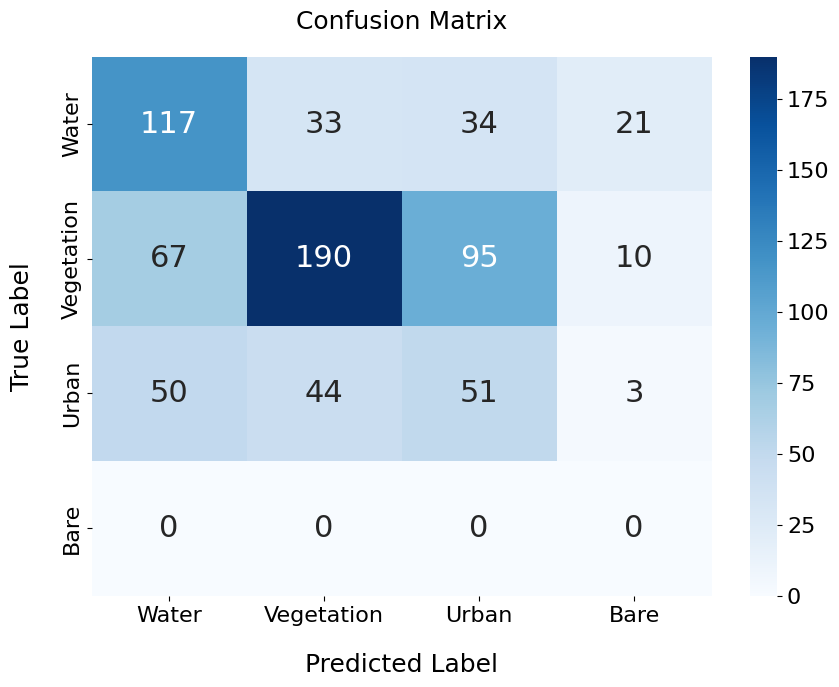

In [ ]:
# Load Sentinel-2 data for Inverness
sentinel2_inverness = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(inverness_roi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .median() \
    .clip(inverness_roi) \
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])

sentinel2_inverness = sentinel2_inverness.divide(10000)  # Normalize

# Combine Sentinel-2 bands and WorldCover labels for Inverness training
training_image_inverness = sentinel2_inverness.addBands(worldcover.select('Map'))

# Sample the combined training image for Inverness
training_data_inverness = training_image_inverness.stratifiedSample(
    region=inverness_roi,
    scale=10,
    numPoints=500,  # Number of training samples per class
    classBand='Map',
    seed=0,
    geometries=True
)

# Check and handle missing values
training_data_inverness = training_data_inverness.filter(ee.Filter.notNull(training_image_inverness.bandNames()))

# Convert training data to GeoJSON and then to GeoDataFrame for outlier detection
training_geojson_inverness = geemap.ee_to_geojson(training_data_inverness)
training_gdf_inverness = gpd.GeoDataFrame.from_features(training_geojson_inverness['features'])

# Filter only the relevant labels: Water (10), Land (90), Urbanization (40), Vegetation (30)
filtered_training_gdf_inverness = training_gdf_inverness[training_gdf_inverness['Map'].isin([10, 30, 40, 90])]

# Calculate z-scores to identify outliers
z_scores_inverness = np.abs(stats.zscore(filtered_training_gdf_inverness[['B2', 'B3', 'B4', 'B8', 'B11', 'B12']]))
filtered_entries_inverness = (z_scores_inverness < 3).all(axis=1)

# Filter out outliers
cleaned_training_gdf_inverness = filtered_training_gdf_inverness[filtered_entries_inverness]

# Convert back to ee.FeatureCollection
def gdf_to_ee_feature_collection(gdf):
    features = []
    for _, row in gdf.iterrows():
        geom = row['geometry']
        if isinstance(geom, Point):
            ee_geom = ee.Geometry.Point([geom.x, geom.y])
        elif isinstance(geom, LineString):
            ee_geom = ee.Geometry.LineString(geom.coords)
        elif isinstance(geom, Polygon):
            ee_geom = ee.Geometry.Polygon([list(geom.exterior.coords)])
        else:
            raise TypeError(f"Unsupported geometry type: {type(geom)}")

        prop = row.drop(labels='geometry').to_dict()
        features.append(ee.Feature(ee_geom, prop))
    return ee.FeatureCollection(features)

cleaned_training_data_inverness = gdf_to_ee_feature_collection(cleaned_training_gdf_inverness)

# Balance classes in training data
class_counts_inverness = cleaned_training_data_inverness.aggregate_histogram('Map').getInfo()
min_count_inverness = min(class_counts_inverness.values())
balanced_training_data_inverness = cleaned_training_data_inverness.filter(ee.Filter.lte('Map', min_count_inverness))

# Convert cleaned and balanced training data to a Pandas DataFrame for scikit-learn
training_geojson_balanced_inverness = geemap.ee_to_geojson(balanced_training_data_inverness)
training_gdf_balanced_inverness = gpd.GeoDataFrame.from_features(training_geojson_balanced_inverness['features'])

# Extract features and labels
X_inverness = training_gdf_balanced_inverness[['B2', 'B3', 'B4', 'B8', 'B11', 'B12']]
y_inverness = training_gdf_balanced_inverness['Map']

# Define class weights for the four classes
class_weights_inverness = {
    10: 1,  # Water
    30: 1,  # Vegetation
    40: 10, # Urbanization
    90: 1   # Land
}

# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of Trees
    'max_features': [4, 6],          # Number of features to consider
    'min_samples_leaf': [1, 2, 5],   # Minimum number of samples per leaf
    'bootstrap': [True, False]       # Whether to use bootstrap samples
}

# Train the Random Forest model
rf = RandomForestClassifier(random_state=0, class_weight=class_weights_inverness)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_inverness, y_inverness)

# Train the classifier with the best parameters on the full dataset
best_rf = grid_search.best_estimator_
best_rf.fit(X_inverness, y_inverness)

# Load Sentinel-2 data for Edinburgh
sentinel2_edinburgh = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(edinburgh_roi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .median() \
    .clip(edinburgh_roi) \
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])

sentinel2_edinburgh = sentinel2_edinburgh.divide(10000)  # Normalize

# Classify the Edinburgh Sentinel-2 image using the trained classifier
classified_image = sentinel2_edinburgh.classify(
    ee.Classifier.smileRandomForest(
        numberOfTrees=grid_search.best_params_['n_estimators'],
        variablesPerSplit=grid_search.best_params_['max_features'],
        minLeafPopulation=grid_search.best_params_['min_samples_leaf'],
        bagFraction=1 if grid_search.best_params_['bootstrap'] else 0.5,
        seed=0
    ).train(
        features=balanced_training_data_inverness,
        classProperty='Map',
        inputProperties=['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
    )
)

# Sample the classified image to get predictions
predicted_samples = classified_image.sample(
    region=edinburgh_roi,
    scale=10,
    numPixels=1000,  # Increase the number of pixels to sample
    geometries=True
)

# Sample the true labels from WorldCover for Edinburgh
true_samples = worldcover.sample(
    region=edinburgh_roi,
    scale=10,
    numPixels=1000,  # Increase the number of pixels to sample
    geometries=True
)

# Convert sampled predictions to GeoJSON and then to GeoDataFrame
predicted_geojson = geemap.ee_to_geojson(predicted_samples)
predicted_gdf = gpd.GeoDataFrame.from_features(predicted_geojson['features'])

# Adjust column names for true labels
true_geojson = geemap.ee_to_geojson(true_samples)
true_gdf = gpd.GeoDataFrame.from_features(true_geojson['features'])

# Ensure 'Map' is of integer type
true_gdf['Map'] = true_gdf['Map'].astype(int)

# Extract the predicted and true labels
y_pred = predicted_gdf.get('classification', None)  # Adjust this if the key is different
if y_pred is None:
    raise ValueError("Predicted labels are not found. Check the prediction process.")

y_true = true_gdf['Map'].values
mod1_y_pred = predicted_gdf['classification'].values



**Performance Metrics**

Accuracy: 0.36
Kappa Coefficient: 0.18
Classification Report:
              precision    recall  f1-score   support

       Water       0.34      0.57      0.43       205
  Vegetation       0.58      0.52      0.55       362
       Urban       0.25      0.34      0.29       148
        Bare       0.00      0.00      0.00         0

   micro avg       0.36      0.50      0.42       715
   macro avg       0.29      0.36      0.32       715
weighted avg       0.44      0.50      0.46       715

Confusion Matrix:
[[117  33  34  21]
 [ 67 190  95  10]
 [ 50  44  51   3]
 [  0   0   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


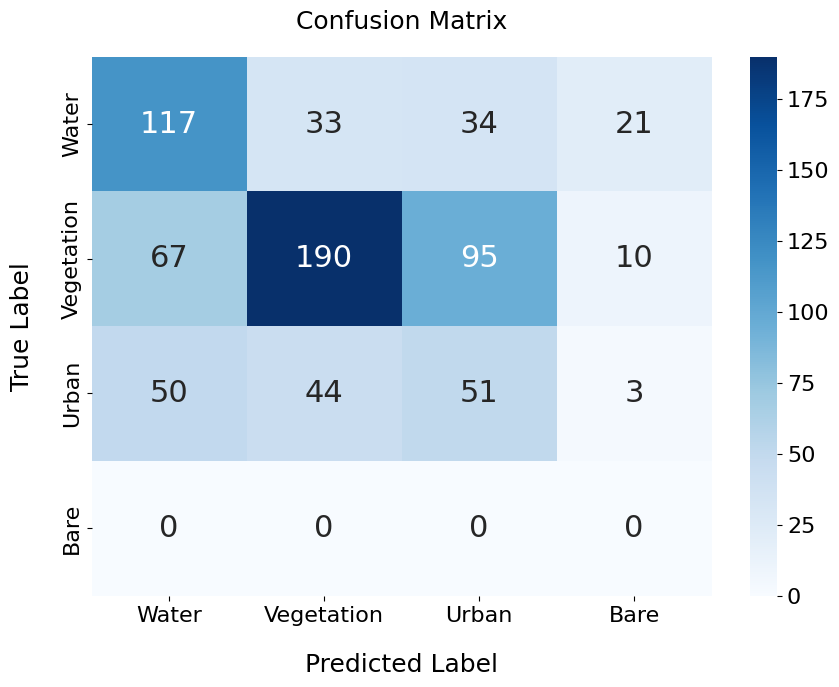

In [ ]:
# Define class names
class_names = {
    10: 'Water',
    30: 'Vegetation',
    40: 'Urban',
    90: 'Bare'
}

# Get unique classes in y_true and y_pred
unique_classes = np.unique(np.concatenate((y_true, y_pred)))

# Match actual class names with unique classes in the data
labels = [cls for cls in unique_classes if cls in class_names]

# Print accuracy and kappa
mod1_accuracy = accuracy_score(y_true, mod1_y_pred)
mod1_kappa = cohen_kappa_score(y_true, mod1_y_pred)
print(f"Accuracy: {mod1_accuracy:.2f}")
print(f"Kappa Coefficient: {mod1_kappa:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, mod1_y_pred, target_names=[class_names[cls] for cls in labels], labels=labels))

# Compute and print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 annot_kws={"size": 22},
                 xticklabels=[class_names[cls] for cls in labels],
                 yticklabels=[class_names[cls] for cls in labels],
                 cbar=True)
plt.xlabel('Predicted Label', fontsize=18, labelpad=20)
plt.ylabel('True Label', fontsize=18, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.title('Confusion Matrix', fontsize=18, pad=20)
plt.show()


**Map Visualization**

In [ ]:
# Define a color palette and class names for the land cover classes
landcover_palette = {
    10: ('Water', '#1A5BAB'),        # Blue for Water (same as ESA)
    30: ('Vegetation', '#15A43A'),   # Green for Vegetation (same as ESA)
    40: ('Urban', '#E31A1C'),        # Red for Urban (same as ESA)
    90: ('Bare', '#D8D83E')          # Yellow for Bare (same as ESA)
}

# Create a list of colors and a list of class values
colors = [landcover_palette[key][1] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Create a map centered on Edinburgh
Map = geemap.Map(center=[55.9533, -3.1883], zoom=10)

# Add the classified image to the map
Map.addLayer(classified_image.clip(edinburgh_roi), {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}, 'Classified Land Cover')

# Add a legend to the map
legend_dict = {landcover_palette[key][0]: landcover_palette[key][1] for key in landcover_palette}
Map.add_legend(legend_title="Land Cover Classification", legend_dict=legend_dict)

# Display the map
Map


Map(center=[55.9533, -3.1883], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

# Model 2: LightGBM Classifier

**Model Training and Testing**

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1012, number of used features: 6
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

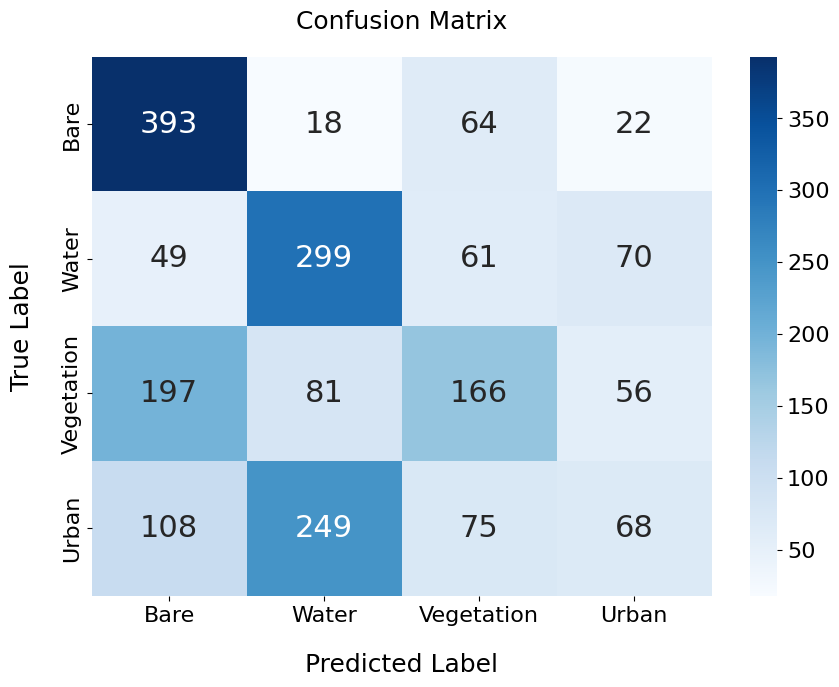

In [ ]:
# Normalize Sentinel-2 bands
def normalize(image):
    return image.divide(10000)

# Function to map WorldCover classes to the desired categories
def map_classes(image):
    return image.remap(
        [10, 20, 30, 40, 50, 60, 70, 80, 90, 95],
        [2, 2, 0, 2, 1, 0, 2, 1, 3, 0],
        0
    )

# Process and prepare training data from Inverness
def prepare_training_data(roi):
    worldcover_image = worldcover.clip(roi)
    mapped_worldcover = map_classes(worldcover_image)

    sentinel2_image = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .median() \
        .clip(roi) \
        .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])

    sentinel2_image = normalize(sentinel2_image)
    training_image = sentinel2_image.addBands(mapped_worldcover.rename('Map'))
    training_data = training_image.stratifiedSample(
        region=roi,
        scale=10,
        numPoints=500,
        classBand='Map',
        seed=0,
        geometries=True
    )
    training_data = training_data.filter(ee.Filter.notNull(training_image.bandNames()))
    training_geojson = geemap.ee_to_geojson(training_data)
    training_gdf = gpd.GeoDataFrame.from_features(training_geojson['features'])

    numeric_columns = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
    z_scores = np.abs(stats.zscore(training_gdf[numeric_columns]))
    filtered_entries = (z_scores < 3).all(axis=1)
    cleaned_training_gdf = training_gdf[filtered_entries]

    return cleaned_training_gdf

# Prepare training data from Inverness
training_gdf = prepare_training_data(inverness_roi)

# Balance classes in training data with SMOTEENN
smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
X_train = training_gdf[['B2', 'B3', 'B4', 'B8', 'B11', 'B12']]
y_train = training_gdf['Map']
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Define and train the LightGBM model with class weights and resampled data
lgbm = LGBMClassifier(random_state=0, class_weight='balanced')
lgbm.fit(X_resampled, y_resampled)

# Process and prepare test data from Edinburgh
def prepare_test_data(roi):
    worldcover_image = worldcover.clip(roi)
    mapped_worldcover = map_classes(worldcover_image)

    sentinel2_image = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .median() \
        .clip(roi) \
        .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])

    sentinel2_image = normalize(sentinel2_image)
    test_image = sentinel2_image.addBands(mapped_worldcover.rename('Map'))
    test_data = test_image.stratifiedSample(
        region=roi,
        scale=10,
        numPoints=500,
        classBand='Map',
        seed=0,
        geometries=True
    )
    test_data = test_data.filter(ee.Filter.notNull(test_image.bandNames()))
    test_geojson = geemap.ee_to_geojson(test_data)
    test_gdf = gpd.GeoDataFrame.from_features(test_geojson['features'])

    numeric_columns = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
    z_scores = np.abs(stats.zscore(test_gdf[numeric_columns]))
    filtered_entries = (z_scores < 3).all(axis=1)
    cleaned_test_gdf = test_gdf[filtered_entries]

    return cleaned_test_gdf

# Prepare test data from Edinburgh
test_gdf = prepare_test_data(edinburgh_roi)

# Extract features and labels for testing
X_test = test_gdf[['B2', 'B3', 'B4', 'B8', 'B11', 'B12']]
y_test = test_gdf['Map']

# Predict on the test set
mod2_y_pred = lgbm.predict(X_test)
accuracy = accuracy_score(y_test, mod2_y_pred)
kappa = cohen_kappa_score(y_test, mod2_y_pred)
print("Accuracy: ", accuracy)
print("Kappa Coefficient: ", kappa)

# Define class labels mapping
class_labels = {
    0: 'Bare',
    1: 'Water',
    2: 'Vegetation',
    3: 'Urban'
}

# Create a list of labels in order
labels = [class_labels[key] for key in sorted(class_labels.keys())]

# Classification Report
print("Classification Report:\n", classification_report(
    y_test,
    mod2_y_pred,
    target_names=labels,
    labels=sorted(class_labels.keys())
))

# Compute confusion matrix
conf_matrix = confusion_matrix(
    y_test,
    mod2_y_pred,
    labels=sorted(class_labels.keys())
)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    annot_kws={"size": 22},
    xticklabels=labels,
    yticklabels=labels,
    cbar=True
)
plt.xlabel('Predicted Label', fontsize=18, labelpad=20)
plt.ylabel('True Label', fontsize=18, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.title('Confusion Matrix', fontsize=18, pad=20)
plt.show()


**Map Visualization**

In [ ]:
# Add predictions to the test GeoDataFrame
test_gdf['predicted_class'] = mod2_y_pred

# Convert the GeoDataFrame with predictions back to ee.FeatureCollection
def gdf_to_ee_feature_collection(gdf):
    features = []
    for _, row in gdf.iterrows():
        geom = row['geometry']
        if isinstance(geom, Point):
            ee_geom = ee.Geometry.Point([geom.x, geom.y])
        elif isinstance(geom, LineString):
            ee_geom = ee.Geometry.LineString(geom.coords)
        elif isinstance(geom, Polygon):
            ee_geom = ee.Geometry.Polygon([list(geom.exterior.coords)])
        else:
            raise TypeError(f"Unsupported geometry type: {type(geom)}")

        prop = row.drop(labels='geometry').to_dict()
        features.append(ee.Feature(ee_geom, prop))
    return ee.FeatureCollection(features)

# Convert to ee.FeatureCollection
predicted_features = gdf_to_ee_feature_collection(test_gdf)

# Create an ee.Image from the predicted features
classified_image = ee.Image().paint(predicted_features, 'predicted_class')

# Define a color palette and class names for the land cover classes
landcover_palette = {
    0: ('Bare', '#D8D83E'),           # Yellow for Bare
    1: ('Water', '#1A5BAB'),          # Blue for Water
    2: ('Vegetation', '#15A43A'),     # Green for Vegetation
    3: ('Urban', '#E31A1C')           # Red for Urbanization
}

# Create a list of colors and a list of class values
colors = [landcover_palette[key][1] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Create a map centered on Edinburgh
Map = geemap.Map(center=[55.9533, -3.1883], zoom=10)

# Add the classified image to the map
Map.addLayer(classified_image.clip(edinburgh_roi), {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}, 'Classified Land Cover')

# Add a legend to the map
legend_dict = {landcover_palette[key][0]: landcover_palette[key][1] for key in landcover_palette}
Map.add_legend(legend_title="Land Cover Classification", legend_dict=legend_dict)

# Display the map
Map


Map(center=[55.9533, -3.1883], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

Note: Predictions of the LightGBM classifier cannot be visualized in GEE, we can only see random isolated points, which is not useful for the purpose of this project.

# Model 3: Classification and Regression Tree (CART)

**Model Training and Testing**

In [ ]:
# Load Sentinel-2 data for Inverness
sentinel2_inverness = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(inverness_roi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .median() \
    .clip(inverness_roi) \
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])

sentinel2_inverness = sentinel2_inverness.divide(10000)  # Normalize

# Combine Sentinel-2 bands and WorldCover labels for Inverness training
training_image_inverness = sentinel2_inverness.addBands(worldcover.select('Map'))

# Sample the combined training image for Inverness
training_data_inverness = training_image_inverness.stratifiedSample(
    region=inverness_roi,
    scale=10,
    numPoints=500,  # Number of training samples per class
    classBand='Map',
    seed=0,
    geometries=True
)

# Check and handle missing values
training_data_inverness = training_data_inverness.filter(ee.Filter.notNull(training_image_inverness.bandNames()))

# Convert training data to GeoJSON and then to GeoDataFrame for outlier detection
training_geojson_inverness = geemap.ee_to_geojson(training_data_inverness)
training_gdf_inverness = gpd.GeoDataFrame.from_features(training_geojson_inverness['features'])

# Filter only the relevant labels: Water (10), Land (90), Urbanization (40), Vegetation (30)
filtered_training_gdf_inverness = training_gdf_inverness[training_gdf_inverness['Map'].isin([10, 30, 40, 90])]

# Calculate z-scores to identify outliers
z_scores_inverness = np.abs(stats.zscore(filtered_training_gdf_inverness[['B2', 'B3', 'B4', 'B8', 'B11', 'B12']]))
filtered_entries_inverness = (z_scores_inverness < 3).all(axis=1)

# Filter out outliers
cleaned_training_gdf_inverness = filtered_training_gdf_inverness[filtered_entries_inverness]

# Convert back to ee.FeatureCollection
def gdf_to_ee_feature_collection(gdf):
    features = []
    for _, row in gdf.iterrows():
        geom = row['geometry']
        if isinstance(geom, Point):
            ee_geom = ee.Geometry.Point([geom.x, geom.y])
        elif isinstance(geom, LineString):
            ee_geom = ee.Geometry.LineString(geom.coords)
        elif isinstance(geom, Polygon):
            ee_geom = ee.Geometry.Polygon([list(geom.exterior.coords)])
        else:
            raise TypeError(f"Unsupported geometry type: {type(geom)}")

        prop = row.drop(labels='geometry').to_dict()
        features.append(ee.Feature(ee_geom, prop))
    return ee.FeatureCollection(features)

cleaned_training_data_inverness = gdf_to_ee_feature_collection(cleaned_training_gdf_inverness)

# Balance classes in training data
class_counts_inverness = cleaned_training_data_inverness.aggregate_histogram('Map').getInfo()
min_count_inverness = min(class_counts_inverness.values())
balanced_training_data_inverness = cleaned_training_data_inverness.filter(ee.Filter.lte('Map', min_count_inverness))

# Load Sentinel-2 data for Edinburgh
sentinel2_edinburgh = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(edinburgh_roi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .median() \
    .clip(edinburgh_roi) \
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])

sentinel2_edinburgh = sentinel2_edinburgh.divide(10000)  # Normalize

# Define and train the CART model with GEE
cart_classifier = ee.Classifier.smileCart().train(
    features=balanced_training_data_inverness,
    classProperty='Map',
    inputProperties=['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
)

# Classify the Edinburgh Sentinel-2 image using the trained CART classifier
classified_image = sentinel2_edinburgh.classify(cart_classifier)

# Sample the classified image to get predictions
predicted_samples = classified_image.sample(
    region=edinburgh_roi,
    scale=10,
    numPixels=1000,  # Increase the number of pixels to sample
    geometries=True
)

# Sample the true labels from WorldCover for Edinburgh
true_samples = worldcover.sample(
    region=edinburgh_roi,
    scale=10,
    numPixels=1000,  # Increase the number of pixels to sample
    geometries=True
)

# Convert sampled predictions to GeoJSON and then to GeoDataFrame
predicted_geojson = geemap.ee_to_geojson(predicted_samples)
predicted_gdf = gpd.GeoDataFrame.from_features(predicted_geojson['features'])

# Adjust column names for true labels
true_geojson = geemap.ee_to_geojson(true_samples)
true_gdf = gpd.GeoDataFrame.from_features(true_geojson['features'])

# Ensure 'Map' is of integer type
true_gdf['Map'] = true_gdf['Map'].astype(int)

# Extract the predicted and true labels
y_pred = predicted_gdf['classification'].values
y_true = true_gdf['Map'].values



**Performance metrics**

Accuracy: 0.31
Kappa Coefficient: 0.10
Classification Report:
              precision    recall  f1-score   support

       Water       0.28      0.36      0.31       205
  Vegetation       0.47      0.50      0.48       362
       Urban       0.22      0.35      0.27       148
        Bare       0.00      0.00      0.00         0

   micro avg       0.31      0.43      0.36       715
   macro avg       0.24      0.30      0.27       715
weighted avg       0.36      0.43      0.39       715

Confusion Matrix:
[[ 74  64  45  22]
 [ 59 181 111  11]
 [ 42  52  52   2]
 [  0   0   0   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


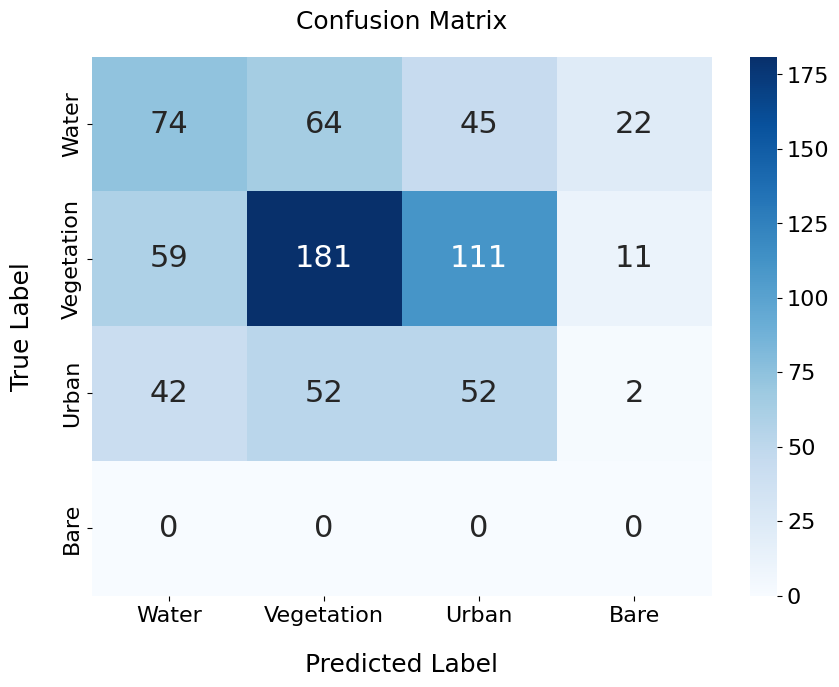

In [ ]:
# Define class names
class_names = {
    10: 'Water',
    30: 'Vegetation',
    40: 'Urban',
    90: 'Bare'
}

# Get unique classes in y_true and y_pred
unique_classes = np.unique(np.concatenate((y_true, y_pred)))

# Match actual class names with unique classes in the data
labels = [cls for cls in unique_classes if cls in class_names]

# Print accuracy and kappa
accuracy = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa Coefficient: {kappa:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[class_names[cls] for cls in labels], labels=labels))

# Compute and print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 annot_kws={"size": 22},
                 xticklabels=[class_names[cls] for cls in labels],
                 yticklabels=[class_names[cls] for cls in labels],
                 cbar=True)
plt.xlabel('Predicted Label', fontsize=18, labelpad=20)
plt.ylabel('True Label', fontsize=18, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.title('Confusion Matrix', fontsize=18, pad=20)
plt.show()


**Map Visualization**

In [ ]:
# Define a color palette and class names for the land cover classes
landcover_palette = {
    10: ('Water', '#1A5BAB'),        # Blue for Water (same as ESA)
    30: ('Vegetation', '#15A43A'),   # Green for Vegetation (same as ESA)
    40: ('Urban', '#E31A1C'),        # Red for Urban (same as ESA)
    90: ('Bare', '#D8D83E')          # Yellow for Land (same as Bare in ESA)
}

# Create a list of colors and a list of class values
colors = [landcover_palette[key][1] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Create a map centered on Edinburgh
Map = geemap.Map(center=[55.9533, -3.1883], zoom=10)

# Add the classified image to the map
Map.addLayer(classified_image.clip(edinburgh_roi), {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}, 'Classified Land Cover')

# Add a legend to the map
legend_dict = {landcover_palette[key][0]: landcover_palette[key][1] for key in landcover_palette}
Map.add_legend(legend_title="Land Cover Classification", legend_dict=legend_dict)

# Display the map
Map


Map(center=[55.9533, -3.1883], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

# Model 4: Support Vector Machine (SVM)

**Model Training and Testing**

In [ ]:
# Load Sentinel-2 data for Inverness
sentinel2_inverness = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(inverness_roi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .median() \
    .clip(inverness_roi) \
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])

# Add NDVI
ndvi = sentinel2_inverness.normalizedDifference(['B8', 'B4']).rename('NDVI')
sentinel2_inverness = sentinel2_inverness.addBands(ndvi)
sentinel2_inverness = sentinel2_inverness.divide(10000)  # Normalize

# Combine Sentinel-2 bands and WorldCover labels for Inverness training
training_image_inverness = sentinel2_inverness.addBands(worldcover.select('Map'))

# Sample the combined training image for Inverness
training_data_inverness = training_image_inverness.stratifiedSample(
    region=inverness_roi,
    scale=10,
    numPoints=500,  # Number of training samples per class
    classBand='Map',
    seed=0,
    geometries=True
)

# Check and handle missing values
training_data_inverness = training_data_inverness.filter(ee.Filter.notNull(training_image_inverness.bandNames()))

# Convert training data to GeoJSON and then to GeoDataFrame for outlier detection
training_geojson_inverness = geemap.ee_to_geojson(training_data_inverness)
training_gdf_inverness = gpd.GeoDataFrame.from_features(training_geojson_inverness['features'])

# Filter only the relevant labels: Water (10), Land (90), Urbanization (40), Vegetation (30)
filtered_training_gdf_inverness = training_gdf_inverness[training_gdf_inverness['Map'].isin([10, 30, 40, 90])]

# Calculate z-scores to identify outliers
z_scores_inverness = np.abs(stats.zscore(filtered_training_gdf_inverness[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI']]))
filtered_entries_inverness = (z_scores_inverness < 3).all(axis=1)

# Filter out outliers
cleaned_training_gdf_inverness = filtered_training_gdf_inverness[filtered_entries_inverness]

# Balance classes in training data
class_counts_inverness = cleaned_training_gdf_inverness['Map'].value_counts()
min_count_inverness = class_counts_inverness.min()
balanced_training_gdf_inverness = cleaned_training_gdf_inverness.groupby('Map').apply(lambda x: x.sample(min_count_inverness)).reset_index(drop=True)

# Extract features and labels
X_inverness = balanced_training_gdf_inverness[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI']]
y_inverness = balanced_training_gdf_inverness['Map']

# Oversample the minority class using SMOTE
smote = SMOTE(random_state=42)
X_inverness_resampled, y_inverness_resampled = smote.fit_resample(X_inverness, y_inverness)

# Perform hyperparameter tuning using GridSearchCV with a wider range of parameters
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, refit=True, verbose=2, cv=5)
grid.fit(X_inverness_resampled, y_inverness_resampled)

# Print the best parameters found by GridSearchCV
print(f'Best Parameters: {grid.best_params_}')

# Train the SVM model with the best parameters
best_svm = grid.best_estimator_
best_svm.fit(X_inverness_resampled, y_inverness_resampled)

# Load Sentinel-2 data for Edinburgh
sentinel2_edinburgh = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(edinburgh_roi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .median() \
    .clip(edinburgh_roi) \
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])

# Add NDVI
ndvi_edinburgh = sentinel2_edinburgh.normalizedDifference(['B8', 'B4']).rename('NDVI')
sentinel2_edinburgh = sentinel2_edinburgh.addBands(ndvi_edinburgh)
sentinel2_edinburgh = sentinel2_edinburgh.divide(10000)  # Normalize

# Classify the Edinburgh Sentinel-2 image using the trained classifier
def classify_image(image, classifier):
    features = image.sample(scale=10, numPixels=1000, geometries=True)
    features_geojson = geemap.ee_to_geojson(features)
    features_gdf = gpd.GeoDataFrame.from_features(features_geojson['features'])
    X = features_gdf[['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI']]
    y_pred = classifier.predict(X)
    features_gdf['classification'] = y_pred
    return features_gdf

predicted_gdf = classify_image(sentinel2_edinburgh, best_svm)

# Sample the true labels from WorldCover for Edinburgh
true_samples = worldcover.sample(
    region=edinburgh_roi,
    scale=10,
    numPixels=1000,  # Increase the number of pixels to sample
    geometries=True
)

# Adjust column names for true labels
true_geojson = geemap.ee_to_geojson(true_samples)
true_gdf = gpd.GeoDataFrame.from_features(true_geojson['features'])

# Ensure 'Map' is of integer type
true_gdf['Map'] = true_gdf['Map'].astype(int)

# Extract the predicted and true labels
y_pred = predicted_gdf['classification'].values
y_true = true_gdf['Map'].values


Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END .......................C=0.01, gamma=10, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.01, gamma=10, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.01, gamma=10, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.01, gamma=10, kernel=rbf; total time=   0.2s
[CV] END .......................C=0.01, gamma=10, kernel=rbf; total time=   0.2s
[CV] END ......................C=0.01, gamma=10, kernel=poly; total time=   0.1s
[CV] END ......................C=0.01, gamma=10, kernel=poly; total time=   0.1s
[CV] END ......................C=0.01, gamma=10, kernel=poly; total time=   0.1s
[CV] END ......................C=0.01, gamma=10, kernel=poly; total time=   0.1s
[CV] END ......................C=0.01, gamma=10, kernel=poly; total time=   0.1s
[CV] END ...................C=0.01, gamma=10, kernel=sigmoid; total time=   0.3s
[CV] END ...................C=0.01, gamma=10, 

**Performance Metrics**

Accuracy: 0.36
Kappa Coefficient: 0.17
Classification Report:
              precision    recall  f1-score   support

       Water       0.34      0.60      0.43       205
  Vegetation       0.58      0.52      0.55       362
       Urban       0.23      0.30      0.26       148
        Bare       0.00      0.00      0.00         0

   micro avg       0.36      0.50      0.42       715
   macro avg       0.29      0.35      0.31       715
weighted avg       0.44      0.50      0.46       715

Confusion Matrix:
[[122  38  32  13]
 [ 70 190  97   5]
 [ 59  41  44   4]
 [  0   0   0   0]]


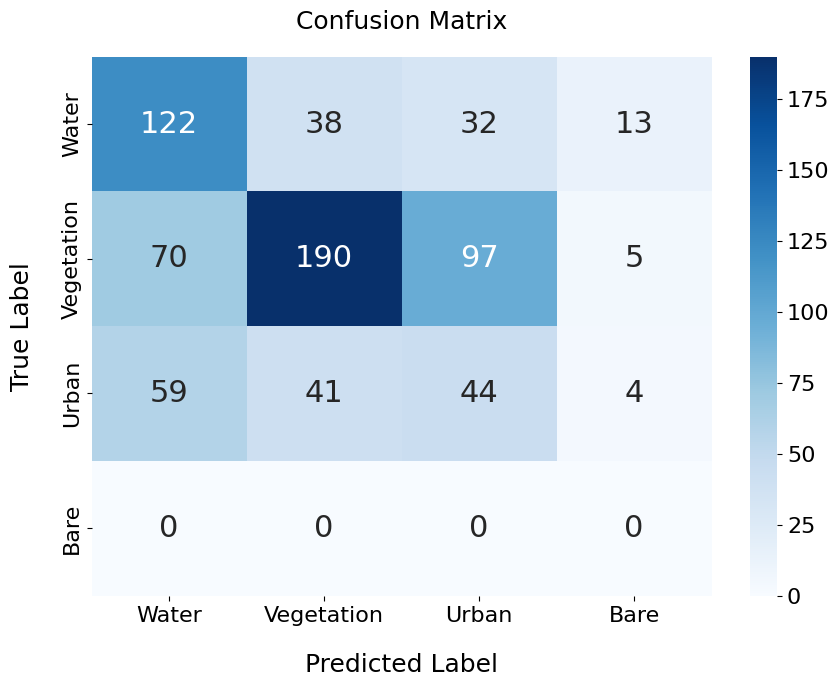

In [ ]:
# Define class names
class_names = {
    10: 'Water',
    30: 'Vegetation',
    40: 'Urban',
    90: 'Bare'
}

# Get unique classes in y_true and y_pred
unique_classes = np.unique(np.concatenate((y_true, y_pred)))

# Match actual class names with unique classes in the data
labels = [cls for cls in unique_classes if cls in class_names]

# Print accuracy and kappa
accuracy = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa Coefficient: {kappa:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[class_names[cls] for cls in labels], labels=labels))

# Compute and print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 annot_kws={"size": 22},
                 xticklabels=[class_names[cls] for cls in labels],
                 yticklabels=[class_names[cls] for cls in labels],
                 cbar=True)
plt.xlabel('Predicted Label', fontsize=18, labelpad=20)
plt.ylabel('True Label', fontsize=18, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.title('Confusion Matrix', fontsize=18, pad=20)
plt.show()

**Map Visualization**

In [ ]:
# Define a color palette and class names for the land cover classes
landcover_palette = {
    10: ('Water', '#1A5BAB'),        # Blue for Water (same as ESA)
    30: ('Vegetation', '#15A43A'),   # Green for Vegetation (same as ESA)
    40: ('Urban', '#E31A1C'),        # Red for Urban (same as ESA)
    90: ('Bare', '#D8D83E')          # Yellow for Land (same as Bare in ESA)
}

# Create a list of colors and a list of class values
colors = [landcover_palette[key][1] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Create a map centered on Edinburgh
Map = geemap.Map(center=[55.9533, -3.1883], zoom=10)

# Add the classified image to the map
Map.addLayer(classified_image.clip(edinburgh_roi), {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}, 'Classified Land Cover')

# Add a legend to the map
legend_dict = {landcover_palette[key][0]: landcover_palette[key][1] for key in landcover_palette}
Map.add_legend(legend_title="Land Cover Classification", legend_dict=legend_dict)

# Display the map
Map

Map(center=[55.9533, -3.1883], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

# Model 5: Naive Bayes (NB)

**Model Training and Testing**

In [ ]:
# Load Sentinel-2 data for Inverness
sentinel2_inverness = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(inverness_roi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .median() \
    .clip(inverness_roi) \
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])

sentinel2_inverness = sentinel2_inverness.divide(10000)  # Normalize

# Combine Sentinel-2 bands and WorldCover labels for Inverness training
training_image_inverness = sentinel2_inverness.addBands(worldcover.select('Map'))

# Sample the combined training image for Inverness
training_data_inverness = training_image_inverness.stratifiedSample(
    region=inverness_roi,
    scale=10,
    numPoints=500,  # Number of training samples per class
    classBand='Map',
    seed=0,
    geometries=True
)

# Check and handle missing values
training_data_inverness = training_data_inverness.filter(ee.Filter.notNull(training_image_inverness.bandNames()))

# Convert training data to GeoJSON and then to GeoDataFrame for outlier detection
training_geojson_inverness = geemap.ee_to_geojson(training_data_inverness)
training_gdf_inverness = gpd.GeoDataFrame.from_features(training_geojson_inverness['features'])

# Filter only the relevant labels: Water (10), Land (90), Urban (40), Vegetation (30)
filtered_training_gdf_inverness = training_gdf_inverness[training_gdf_inverness['Map'].isin([10, 30, 40, 90])]

# Calculate z-scores to identify outliers
z_scores_inverness = np.abs(stats.zscore(filtered_training_gdf_inverness[['B2', 'B3', 'B4', 'B8', 'B11', 'B12']]))
filtered_entries_inverness = (z_scores_inverness < 3).all(axis=1)

# Filter out outliers
cleaned_training_gdf_inverness = filtered_training_gdf_inverness[filtered_entries_inverness]

# Convert back to ee.FeatureCollection
def gdf_to_ee_feature_collection(gdf):
    features = []
    for _, row in gdf.iterrows():
        geom = row['geometry']
        if isinstance(geom, Point):
            ee_geom = ee.Geometry.Point([geom.x, geom.y])
        elif isinstance(geom, LineString):
            ee_geom = ee.Geometry.LineString(geom.coords)
        elif isinstance(geom, Polygon):
            ee_geom = ee.Geometry.Polygon([list(geom.exterior.coords)])
        else:
            raise TypeError(f"Unsupported geometry type: {type(geom)}")

        prop = row.drop(labels='geometry').to_dict()
        features.append(ee.Feature(ee_geom, prop))
    return ee.FeatureCollection(features)

cleaned_training_data_inverness = gdf_to_ee_feature_collection(cleaned_training_gdf_inverness)

# Balance classes in training data
class_counts_inverness = cleaned_training_data_inverness.aggregate_histogram('Map').getInfo()
min_count_inverness = min(class_counts_inverness.values())
balanced_training_data_inverness = cleaned_training_data_inverness.filter(ee.Filter.lte('Map', min_count_inverness))

# Convert cleaned and balanced training data to a Pandas DataFrame for scikit-learn
training_geojson_balanced_inverness = geemap.ee_to_geojson(balanced_training_data_inverness)
training_gdf_balanced_inverness = gpd.GeoDataFrame.from_features(training_geojson_balanced_inverness['features'])

# Extract features and labels
X_inverness = training_gdf_balanced_inverness[['B2', 'B3', 'B4', 'B8', 'B11', 'B12']]
y_inverness = training_gdf_balanced_inverness['Map']

# Load Sentinel-2 data for Edinburgh
sentinel2_edinburgh = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(edinburgh_roi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .median() \
    .clip(edinburgh_roi) \
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])

sentinel2_edinburgh = sentinel2_edinburgh.divide(10000)  # Normalize

# Train the Naive Bayes model and classify the Edinburgh Sentinel-2 image
classifier = ee.Classifier.smileNaiveBayes().train(
    features=balanced_training_data_inverness,
    classProperty='Map',
    inputProperties=['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
)

classified_image = sentinel2_edinburgh.classify(classifier)

# Sample the classified image to get predictions
predicted_samples = classified_image.sample(
    region=edinburgh_roi,
    scale=10,
    numPixels=1000,  # Increase the number of pixels to sample
    geometries=True
)

# Sample the true labels from WorldCover for Edinburgh
true_samples = worldcover.sample(
    region=edinburgh_roi,
    scale=10,
    numPixels=1000,  # Increase the number of pixels to sample
    geometries=True
)

# Convert sampled predictions to GeoJSON and then to GeoDataFrame
predicted_geojson = geemap.ee_to_geojson(predicted_samples)
predicted_gdf = gpd.GeoDataFrame.from_features(predicted_geojson['features'])

# Adjust column names for true labels
true_geojson = geemap.ee_to_geojson(true_samples)
true_gdf = gpd.GeoDataFrame.from_features(true_geojson['features'])

# Ensure 'Map' is of integer type
true_gdf['Map'] = true_gdf['Map'].astype(int)

# Extract the predicted and true labels
y_pred = predicted_gdf.get('classification', None)  # Adjust this if the key is different
if y_pred is None:
    raise ValueError("Predicted labels are not found. Check the prediction process.")

y_true = true_gdf['Map'].values
mod1_y_pred = predicted_gdf['classification'].values

# Define class names
class_names = {
    10: 'Water',
    30: 'Vegetation',
    40: 'Urban',
    90: 'Land'
}

# Get unique classes
unique_classes = np.unique(np.concatenate((y_true, y_pred)))

# Match actual class names with unique classes in the data
labels = [cls for cls in unique_classes if cls in class_names]


**Performance Metrics**

Accuracy: 0.20
Kappa Coefficient: 0.00
Classification Report:
              precision    recall  f1-score   support

       Water       0.20      1.00      0.34       205
  Vegetation       0.00      0.00      0.00       362
       Urban       0.00      0.00      0.00       148

   micro avg       0.20      0.29      0.24       715
   macro avg       0.07      0.33      0.11       715
weighted avg       0.06      0.29      0.10       715

Confusion Matrix:
[[205   0   0]
 [362   0   0]
 [148   0   0]]


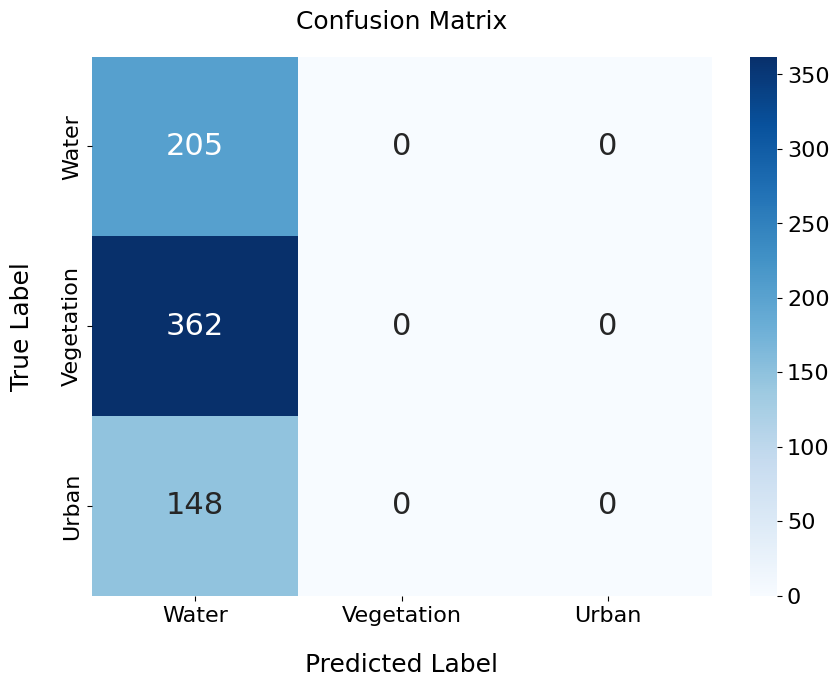

In [ ]:
# Define class names
class_names = {
    10: 'Water',
    30: 'Vegetation',
    40: 'Urban',
    90: 'Bare'
}

# Get unique classes in y_true and y_pred
unique_classes = np.unique(np.concatenate((y_true, y_pred)))

# Match actual class names with unique classes in the data
labels = [cls for cls in unique_classes if cls in class_names]

# Print accuracy and kappa
accuracy = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa Coefficient: {kappa:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[class_names[cls] for cls in labels], labels=labels))

# Compute and print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 annot_kws={"size": 22},
                 xticklabels=[class_names[cls] for cls in labels],
                 yticklabels=[class_names[cls] for cls in labels],
                 cbar=True)
plt.xlabel('Predicted Label', fontsize=18, labelpad=20)
plt.ylabel('True Label', fontsize=18, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.title('Confusion Matrix', fontsize=18, pad=20)
plt.show()

**Map Visualization**

In [ ]:
# Define a color palette and class names for the land cover classes
landcover_palette = {
    10: ('Water', '#1A5BAB'),        # Blue for Water (same as ESA)
    30: ('Vegetation', '#15A43A'),   # Green for Vegetation (same as ESA)
    40: ('Urban', '#E31A1C'),        # Red for Urban (same as ESA)
    90: ('Bare', '#D8D83E')          # Yellow for Land (same as Bare in ESA)
}

# Create a list of colors and a list of class values
colors = [landcover_palette[key][1] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Create a map centered on Edinburgh
Map = geemap.Map(center=[55.9533, -3.1883], zoom=10)

# Add the classified image to the map
Map.addLayer(classified_image.clip(edinburgh_roi), {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}, 'Classified Land Cover')

# Add a legend to the map
legend_dict = {landcover_palette[key][0]: landcover_palette[key][1] for key in landcover_palette}
Map.add_legend(legend_title="Land Cover Classification", legend_dict=legend_dict)

# Display the map
Map

Map(center=[55.9533, -3.1883], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

# Model 6: Minimun Distance

**Model Training and Testing**

In [ ]:
# Load Sentinel-2 data for Inverness
sentinel2_inverness = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(inverness_roi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .median() \
    .clip(inverness_roi) \
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])

sentinel2_inverness = sentinel2_inverness.divide(10000)  # Normalize

# Combine Sentinel-2 bands and WorldCover labels for Inverness training
training_image_inverness = sentinel2_inverness.addBands(worldcover.select('Map'))

# Sample the combined training image for Inverness
training_data_inverness = training_image_inverness.stratifiedSample(
    region=inverness_roi,
    scale=10,
    numPoints=500,  # Number of training samples per class
    classBand='Map',
    seed=0,
    geometries=True
)

# Check and handle missing values
training_data_inverness = training_data_inverness.filter(ee.Filter.notNull(training_image_inverness.bandNames()))

# Convert training data to GeoJSON and then to GeoDataFrame for outlier detection
training_geojson_inverness = geemap.ee_to_geojson(training_data_inverness)
training_gdf_inverness = gpd.GeoDataFrame.from_features(training_geojson_inverness['features'])

# Filter only the relevant labels: Water (10), Land (90), Urbanization (40), Vegetation (30)
filtered_training_gdf_inverness = training_gdf_inverness[training_gdf_inverness['Map'].isin([10, 30, 40, 90])]

# Calculate z-scores to identify outliers
z_scores_inverness = np.abs(stats.zscore(filtered_training_gdf_inverness[['B2', 'B3', 'B4', 'B8', 'B11', 'B12']]))
filtered_entries_inverness = (z_scores_inverness < 3).all(axis=1)

# Filter out outliers
cleaned_training_gdf_inverness = filtered_training_gdf_inverness[filtered_entries_inverness]

# Convert back to ee.FeatureCollection
def gdf_to_ee_feature_collection(gdf):
    features = []
    for _, row in gdf.iterrows():
        geom = row['geometry']
        if isinstance(geom, Point):
            ee_geom = ee.Geometry.Point([geom.x, geom.y])
        elif isinstance(geom, LineString):
            ee_geom = ee.Geometry.LineString(geom.coords)
        elif isinstance(geom, Polygon):
            ee_geom = ee.Geometry.Polygon([list(geom.exterior.coords)])
        else:
            raise TypeError(f"Unsupported geometry type: {type(geom)}")

        prop = row.drop(labels='geometry').to_dict()
        features.append(ee.Feature(ee_geom, prop))
    return ee.FeatureCollection(features)

cleaned_training_data_inverness = gdf_to_ee_feature_collection(cleaned_training_gdf_inverness)

# Balance classes in training data
class_counts_inverness = cleaned_training_data_inverness.aggregate_histogram('Map').getInfo()
min_count_inverness = min(class_counts_inverness.values())
balanced_training_data_inverness = cleaned_training_data_inverness.filter(ee.Filter.lte('Map', min_count_inverness))

# Convert cleaned and balanced training data to a Pandas DataFrame for scikit-learn
training_geojson_balanced_inverness = geemap.ee_to_geojson(balanced_training_data_inverness)
training_gdf_balanced_inverness = gpd.GeoDataFrame.from_features(training_geojson_balanced_inverness['features'])

# Extract features and labels
X_inverness = training_gdf_balanced_inverness[['B2', 'B3', 'B4', 'B8', 'B11', 'B12']]
y_inverness = training_gdf_balanced_inverness['Map']

# Load Sentinel-2 data for Edinburgh
sentinel2_edinburgh = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(edinburgh_roi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .median() \
    .clip(edinburgh_roi) \
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])

sentinel2_edinburgh = sentinel2_edinburgh.divide(10000)  # Normalize

# Train the Minimum Distance classifier and classify the Edinburgh Sentinel-2 image
classifier = ee.Classifier.minimumDistance().train(
    features=balanced_training_data_inverness,
    classProperty='Map',
    inputProperties=['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
)

classified_image = sentinel2_edinburgh.classify(classifier)

# Sample the classified image to get predictions
predicted_samples = classified_image.sample(
    region=edinburgh_roi,
    scale=10,
    numPixels=1000,  # Increase the number of pixels to sample
    geometries=True
)

# Sample the true labels from WorldCover for Edinburgh
true_samples = worldcover.sample(
    region=edinburgh_roi,
    scale=10,
    numPixels=1000,  # Increase the number of pixels to sample
    geometries=True
)

# Convert sampled predictions to GeoJSON and then to GeoDataFrame
predicted_geojson = geemap.ee_to_geojson(predicted_samples)
predicted_gdf = gpd.GeoDataFrame.from_features(predicted_geojson['features'])

# Adjust column names for true labels
true_geojson = geemap.ee_to_geojson(true_samples)
true_gdf = gpd.GeoDataFrame.from_features(true_geojson['features'])

# Ensure 'Map' is of integer type
true_gdf['Map'] = true_gdf['Map'].astype(int)

# Extract the predicted and true labels
y_pred = predicted_gdf.get('classification', None)  # Adjust this if the key is different
if y_pred is None:
    raise ValueError("Predicted labels are not found. Check the prediction process.")

y_true = true_gdf['Map'].values
mod1_y_pred = predicted_gdf['classification'].values

# Define class names
class_names = {
    10: 'Water',
    30: 'Vegetation',
    40: 'Urbanization',
    90: 'Land'
}

# Get unique classes
unique_classes = np.unique(np.concatenate((y_true, y_pred)))

# Match actual class names with unique classes in the data
labels = [cls for cls in unique_classes if cls in class_names]


**Performance Metrics**

Accuracy: 0.20
Kappa Coefficient: 0.07
Classification Report:
              precision    recall  f1-score   support

       Water       0.24      0.16      0.19       205
  Vegetation       0.61      0.40      0.48       362
       Urban       0.15      0.15      0.15       148
        Bare       0.00      0.00      0.00         0

   micro avg       0.20      0.28      0.23       715
   macro avg       0.25      0.18      0.21       715
weighted avg       0.41      0.28      0.33       715

Confusion Matrix:
[[ 33  29  23 120]
 [ 35 145  91  91]
 [ 41  53  22  32]
 [  0   0   0   0]]


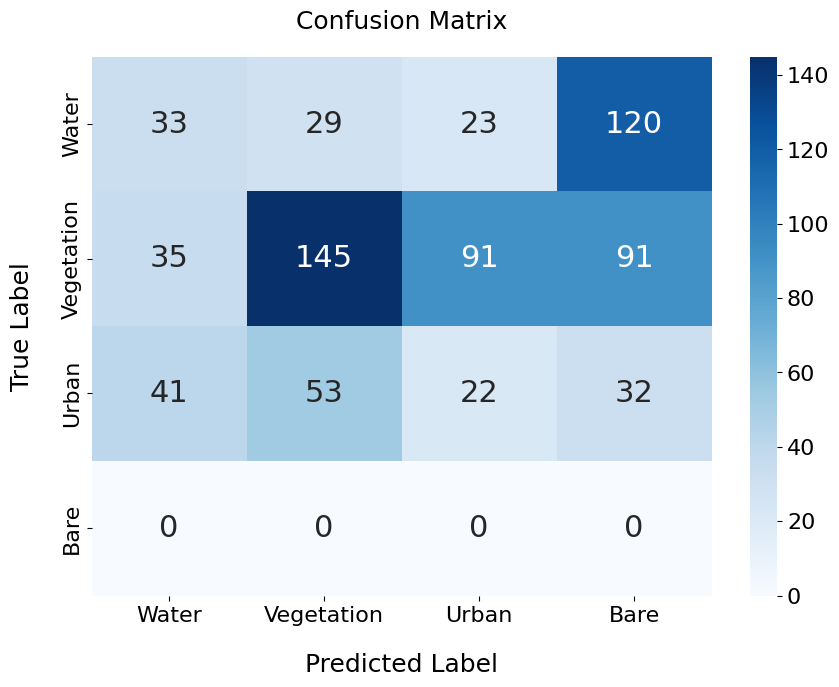

In [ ]:
# Define class names
class_names = {
    10: 'Water',
    30: 'Vegetation',
    40: 'Urban',
    90: 'Bare'
}

# Get unique classes in y_true and y_pred
unique_classes = np.unique(np.concatenate((y_true, y_pred)))

# Match actual class names with unique classes in the data
labels = [cls for cls in unique_classes if cls in class_names]

# Print accuracy and kappa
accuracy = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa Coefficient: {kappa:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=[class_names[cls] for cls in labels], labels=labels))

# Compute and print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 annot_kws={"size": 22},
                 xticklabels=[class_names[cls] for cls in labels],
                 yticklabels=[class_names[cls] for cls in labels],
                 cbar=True)
plt.xlabel('Predicted Label', fontsize=18, labelpad=20)
plt.ylabel('True Label', fontsize=18, labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.title('Confusion Matrix', fontsize=18, pad=20)
plt.show()

**Map Visualization**

In [ ]:
# Define a color palette and class names for the land cover classes
landcover_palette = {
    10: ('Water', '#1A5BAB'),        # Blue for Water (same as ESA)
    30: ('Vegetation', '#15A43A'),   # Green for Vegetation (same as ESA)
    40: ('Urban', '#E31A1C'),        # Red for Urban (same as ESA)
    90: ('Bare', '#D8D83E')          # Yellow for Land (same as Bare in ESA)
}

# Create a list of colors and a list of class values
colors = [landcover_palette[key][1] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Create a map centered on Edinburgh
Map = geemap.Map(center=[55.9533, -3.1883], zoom=10)

# Add the classified image to the map
Map.addLayer(classified_image.clip(edinburgh_roi), {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}, 'Classified Land Cover')

# Add a legend to the map
legend_dict = {landcover_palette[key][0]: landcover_palette[key][1] for key in landcover_palette}
Map.add_legend(legend_title="Land Cover Classification", legend_dict=legend_dict)

# Display the map
Map

Map(center=[55.9533, -3.1883], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

# Model 7: Support Vector Machine (SVM)

**Model Training and Testing**

Accuracy: 0.76
Kappa Coefficient: 0.00
Classification Report:
              precision    recall  f1-score   support

       Other       0.00      0.00      0.00         2
       Urban       0.00      0.00      0.00        69
  Vegetation       0.76      1.00      0.86       227
       Water       0.00      0.00      0.00         2

    accuracy                           0.76       300
   macro avg       0.19      0.25      0.22       300
weighted avg       0.57      0.76      0.65       300

Confusion Matrix:
[[  0   0   2   0]
 [  0   0  69   0]
 [  0   0 227   0]
 [  0   0   2   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


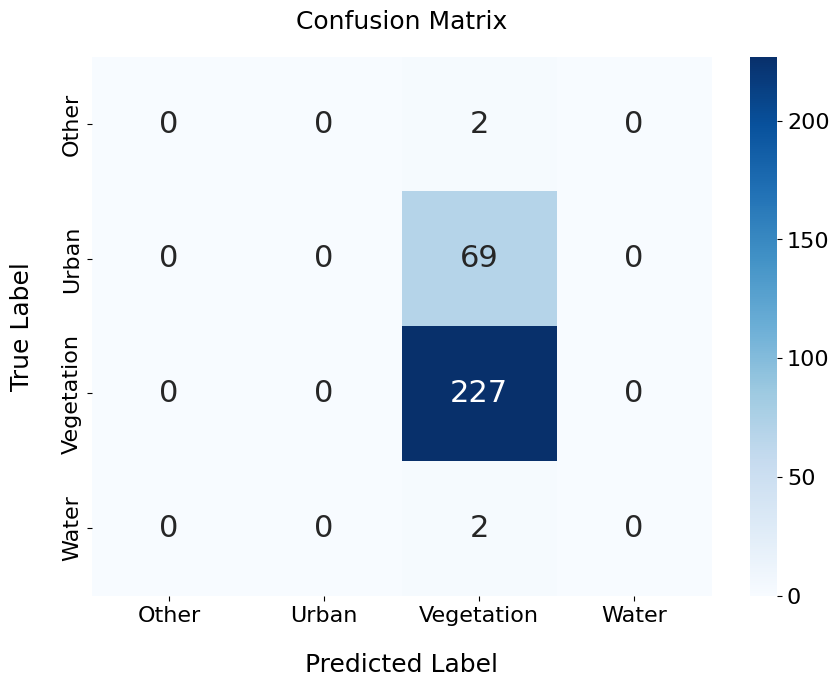

In [ ]:
# Function to load and preprocess Sentinel-2 data for a given region
def load_sentinel2_data(roi):
    sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .median() \
        .clip(roi) \
        .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])
    return sentinel2

# Load Sentinel-2 data for Central London
sentinel2_london = load_sentinel2_data(london_roi)

# Combine Sentinel-2 bands and WorldCover labels for training in Central London
training_image_london = sentinel2_london.addBands(worldcover)

# Sample the combined training images for Central London
training_data_london = training_image_london.stratifiedSample(
    region=london_roi,
    scale=30,  # Increased scale to reduce memory usage
    numPoints=100,
    classBand='Map',
    seed=0,
    geometries=True
)

# Filter only the relevant labels: Water (80), Vegetation (10, 20, 30, 40, 60), Urban (50)
training_data_london = training_data_london.filter(ee.Filter.inList('Map', [10, 20, 30, 40, 50, 60, 80]))

# Train the SVM classifier with London data only
svm_classifier = ee.Classifier.libsvm().train(
    features=training_data_london,
    classProperty='Map',
    inputProperties=['B2', 'B3', 'B4', 'B8', 'B11', 'B12']
)

# Load Sentinel-2 data for Glasgow
sentinel2_glasgow = load_sentinel2_data(glasgow_roi)

# Classify the Glasgow Sentinel-2 image using the trained SVM classifier
classified_glasgow = sentinel2_glasgow.classify(svm_classifier)

# Sample the classified image to get predictions
predicted_samples = classified_glasgow.sample(
    region=glasgow_roi,
    scale=30,  # Increased scale to reduce memory usage
    numPixels=300,
    geometries=True
)

# Convert sampled predictions to GeoJSON and then to GeoDataFrame
predicted_geojson = geemap.ee_to_geojson(predicted_samples)
predicted_gdf = gpd.GeoDataFrame.from_features(predicted_geojson['features'])

# Sample the true labels from WorldCover for Glasgow
true_samples = worldcover.sample(
    region=glasgow_roi,
    scale=30,  # Increased scale to reduce memory usage
    numPixels=300,
    geometries=True
)

# Convert true labels to GeoJSON and then to GeoDataFrame
true_geojson = geemap.ee_to_geojson(true_samples)
true_gdf = gpd.GeoDataFrame.from_features(true_geojson['features'])

# Ensure 'Map' is of integer type
true_gdf['Map'] = true_gdf['Map'].astype(int)

# Define class names mapping for the broader categories
class_names_mapping = {
    10: 'Vegetation',
    20: 'Vegetation',
    30: 'Vegetation',
    40: 'Vegetation',
    60: 'Vegetation',
    50: 'Urban',
    80: 'Water'
}

# Map the predicted and true labels to the broader categories
y_pred = [class_names_mapping.get(label, 'Other') for label in predicted_gdf['classification'].values]
y_true = [class_names_mapping.get(label, 'Other') for label in true_gdf['Map'].values]

# Get unique classes
unique_classes = np.unique(np.concatenate((y_true, y_pred)))

# Match actual class names with unique classes in the data
labels = sorted(unique_classes)

# Print accuracy and kappa
accuracy = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa Coefficient: {kappa:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels, labels=labels))

# Compute and print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 annot_kws={"size": 22},
                 xticklabels=labels,
                 yticklabels=labels,
                 cbar=True)
plt.xlabel('Predicted Label', fontsize=18, labelpad=20)
plt.ylabel('True Label', fontsize=18,labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.title('Confusion Matrix', fontsize=18,pad=20)
plt.show()

**Map Visualization**

In [ ]:
# Define region of interest for Glasgow, Scotland
glasgow_roi = ee.Geometry.Rectangle([-4.4, 55.7, -4.1, 55.9])

# Load Sentinel-2 data for Glasgow
sentinel2_glasgow = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterBounds(glasgow_roi) \
    .filterDate('2020-01-01', '2020-12-31') \
    .median() \
    .clip(glasgow_roi) \
    .select(['B2', 'B3', 'B4', 'B8', 'B11', 'B12'])

# Compute NDVI and add it as a band
ndvi = sentinel2_glasgow.normalizedDifference(['B8', 'B4']).rename('NDVI')
sentinel2_glasgow = sentinel2_glasgow.addBands(ndvi)

# Classify the Glasgow Sentinel-2 image using the trained SVM classifier
classified_glasgow = sentinel2_glasgow.classify(svm_classifier)

# Define a color palette and class names for the land cover classes
landcover_palette = {
    80: ('Water', '#0000FF'),        # Blue for Water
    10: ('Vegetation', '#008000'),   # Green for Vegetation (Class 10)
    20: ('Vegetation', '#008000'),   # Green for Vegetation (Class 20)
    30: ('Vegetation', '#008000'),   # Green for Vegetation (Class 30)
    40: ('Vegetation', '#008000'),   # Green for Vegetation (Class 40)
    50: ('Urban', '#FF69B4'),        # Pink for Urban
    60: ('Vegetation', '#008000')    # Green for Vegetation (Class 60)
}

# Create a list of colors and a list of class values
colors = [landcover_palette[key][1] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Create a map centered on Glasgow
Map = geemap.Map(center=[55.85, -4.25], zoom=10)

# Add the classified image to the map
Map.addLayer(classified_glasgow, {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}, 'Classified Land Cover')

# Add a legend to the map
legend_dict = {landcover_palette[key][0]: landcover_palette[key][1] for key in landcover_palette}
Map.add_legend(legend_title="Land Cover Classification", legend_dict=legend_dict)

# Display the map
Map


Map(center=[55.85, -4.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

# Model 8: Classification and Regression Tree (CART)

**Model Training and Testing**

Accuracy: 0.25
Kappa Coefficient: 0.02
Classification Report:
              precision    recall  f1-score   support

       Other       0.00      0.00      0.00        70
       Urban       0.58      0.19      0.29        37
  Vegetation       0.26      0.76      0.38        41
       Water       0.00      0.00      0.00         2

    accuracy                           0.25       150
   macro avg       0.21      0.24      0.17       150
weighted avg       0.21      0.25      0.18       150

Confusion Matrix:
[[ 0  3 63  4]
 [ 0  7 25  5]
 [ 0  2 31  8]
 [ 0  0  2  0]]


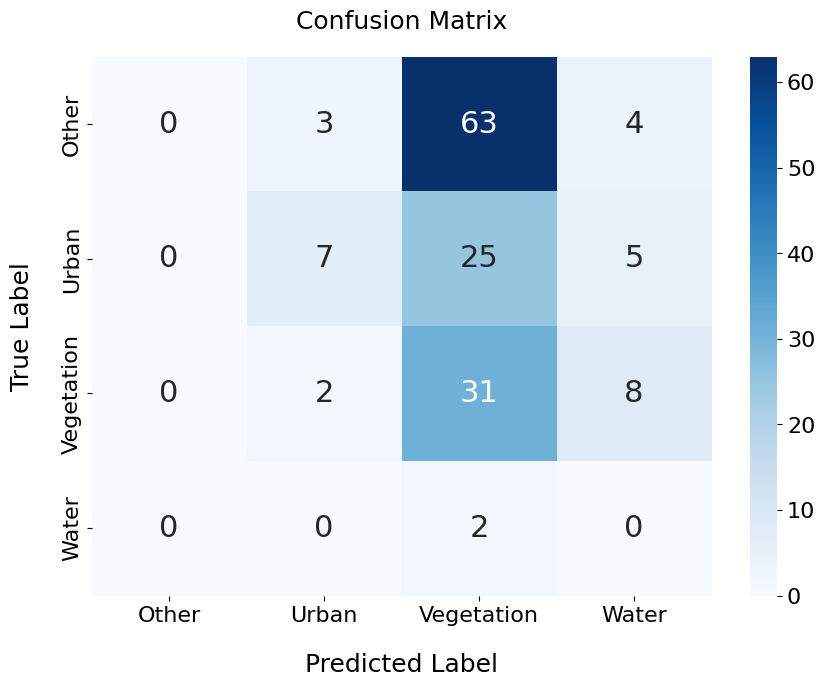

In [ ]:
# Function to load and preprocess Sentinel-2 data for a given region
def load_sentinel2_data(roi):
    sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .median() \
        .clip(roi) \
        .select(['B4', 'B8', 'B11'])  # Use fewer bands to reduce memory usage
    return sentinel2

# Function to load and preprocess Sentinel-1 data for a given region
def load_sentinel1_data(roi):
    sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .select(['VV']) \
        .median() \
        .clip(roi)
    return sentinel1

# Load Sentinel-2 and Sentinel-1 data for the London region
sentinel2_london = load_sentinel2_data(london_roi)
sentinel1_london = load_sentinel1_data(london_roi)

# Combine Sentinel-1 and Sentinel-2 data
combined_london = sentinel2_london.addBands(sentinel1_london)

# Combine Sentinel-2 and Sentinel-1 data with the original WorldCover Map for training
training_image_london = combined_london.addBands(worldcover.rename('Map'))

# Filter the Map to keep only relevant classes: Vegetation (10), Urban (50), Water (80)
filtered_map = worldcover.updateMask(worldcover.eq(10).Or(worldcover.eq(50)).Or(worldcover.eq(80)))

# Combine Sentinel-2 and Sentinel-1 data with the filtered Map labels for training
training_image_london = combined_london.addBands(filtered_map.rename('FilteredMap'))

# Sample the combined training images using the filtered Map band
training_data_london = training_image_london.stratifiedSample(
    region=london_roi,
    scale=20,  # Increase scale to reduce the number of pixels sampled
    numPoints=50,  # Reduce the number of samples per class to lower memory usage
    classBand='FilteredMap',  # Use the filtered class band
    seed=0,
    geometries=True
)

# Train a simpler CART classifier instead of Random Forest
cart_classifier = ee.Classifier.smileCart().train(
    features=training_data_london,
    classProperty='FilteredMap',
    inputProperties=['B4', 'B8', 'B11', 'VV']
)

# Define the region of interest for Glasgow for testing
glasgow_roi = ee.Geometry.Rectangle([-4.4, 55.7, -4.1, 55.9])

# Load Sentinel-2 and Sentinel-1 data for Glasgow
sentinel2_glasgow = load_sentinel2_data(glasgow_roi)
sentinel1_glasgow = load_sentinel1_data(glasgow_roi)

# Combine Sentinel-1 and Sentinel-2 data for Glasgow
combined_glasgow = sentinel2_glasgow.addBands(sentinel1_glasgow)

# Classify the Glasgow Sentinel-1 and Sentinel-2 image using the trained CART classifier
classified_glasgow = combined_glasgow.classify(cart_classifier)

# Sample the classified image to get predictions
predicted_samples = classified_glasgow.sample(
    region=glasgow_roi,
    scale=20,
    numPixels=150,
    geometries=True
)

# Convert sampled predictions to GeoJSON and then to GeoDataFrame
predicted_geojson = geemap.ee_to_geojson(predicted_samples)
predicted_gdf = gpd.GeoDataFrame.from_features(predicted_geojson['features'])

# Sample the true labels from WorldCover for Glasgow
true_samples = worldcover.sample(
    region=glasgow_roi,
    scale=20,
    numPixels=150,
    geometries=True
)

# Convert true labels to GeoJSON and then to GeoDataFrame
true_geojson = geemap.ee_to_geojson(true_samples)
true_gdf = gpd.GeoDataFrame.from_features(true_geojson['features'])

# Ensure 'Map' is of integer type
true_gdf['Map'] = true_gdf['Map'].astype(int)

# Define class names mapping for the broader categories
class_names_mapping = {
    10: 'Vegetation',
    50: 'Urban',
    80: 'Water'
}

# Map the predicted and true labels to the broader categories
y_pred = [class_names_mapping.get(label, 'Other') for label in predicted_gdf['classification'].values]
y_true = [class_names_mapping.get(label, 'Other') for label in true_gdf['Map'].values]

# Get unique classes
unique_classes = np.unique(np.concatenate((y_true, y_pred)))

# Match actual class names with unique classes in the data
labels = sorted(unique_classes)

# Print accuracy and kappa
accuracy = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa Coefficient: {kappa:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels, labels=labels))

# Compute and print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 annot_kws={"size": 22},
                 xticklabels=labels,
                 yticklabels=labels,
                 cbar=True)
plt.xlabel('Predicted Label', fontsize=18, labelpad=20)
plt.ylabel('True Label', fontsize=18,labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.title('Confusion Matrix', fontsize=18,pad=20)
plt.show()

**Map Visualization**

In [ ]:
# Define a color palette and class names for the land cover classes
landcover_palette = {
    10: ('Tree cover', '#006400'),        # Dark green for Tree cover (same as ESA)
    50: ('Urban', '#FA0000'),             # Red for Urban (same as ESA)
    80: ('Water', '#0064C8')              # Blue for Water (same as ESA)
}

# Create a list of colors and a list of class values
colors = [landcover_palette[key][1] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Create a map centered on Glasgow
Map = geemap.Map(center=[55.85, -4.25], zoom=10)

# Add the classified image to the map
Map.addLayer(classified_glasgow, {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}, 'Classified Land Cover')

# Add a legend to the map
legend_dict = {landcover_palette[key][0]: landcover_palette[key][1] for key in landcover_palette}
Map.add_legend(legend_title="Land Cover Classification", legend_dict=legend_dict)

# Display the map
Map


Map(center=[55.85, -4.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

**Reducing the scale=10, increasing numpoints=200**

Accuracy: 0.17
Kappa Coefficient: -0.09
Classification Report:
              precision    recall  f1-score   support

       Other       0.00      0.00      0.00       101
       Urban       0.29      0.62      0.40        50
  Vegetation       0.04      0.09      0.06        46
       Water       0.00      0.00      0.00         3

    accuracy                           0.17       200
   macro avg       0.08      0.18      0.11       200
weighted avg       0.08      0.17      0.11       200

Confusion Matrix:
[[ 0 33 68  0]
 [ 0 31 19  0]
 [ 0 42  4  0]
 [ 0  0  3  0]]


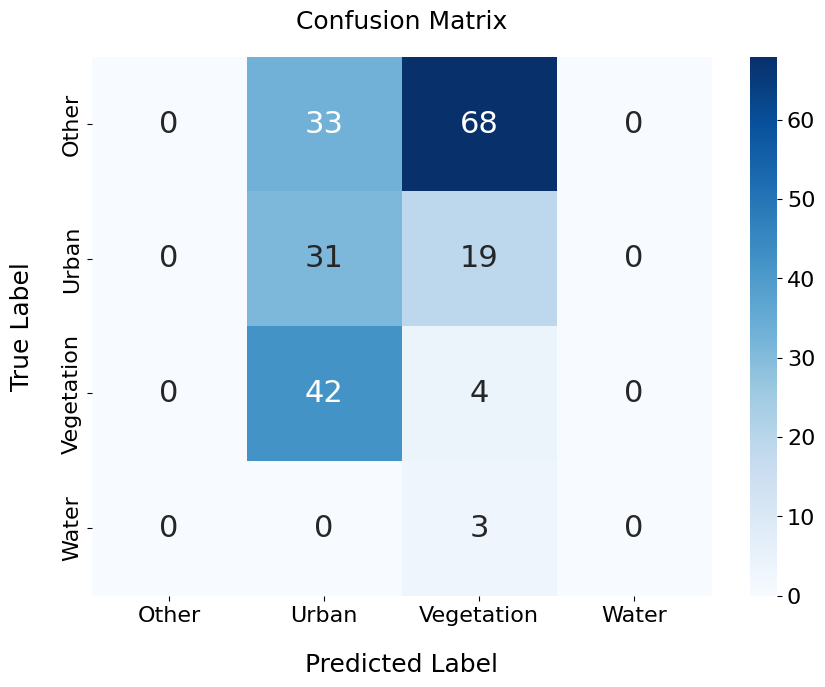

In [ ]:
# Define a region of interest around Westminster, London
london_roi = ee.Geometry.Rectangle([-0.14, 51.49, -0.11, 51.52])  # Westminster, River Thames, and surrounding areas

# Load ESA WorldCover dataset for 2020
worldcover = ee.Image('ESA/WorldCover/v100/2020').select('Map')

# Function to load and preprocess Sentinel-2 data for a given region
def load_sentinel2_data(roi):
    sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .median() \
        .clip(roi) \
        .select(['B4', 'B8', 'B11'])
    return sentinel2

# Function to load and preprocess Sentinel-1 data for a given region
def load_sentinel1_data(roi):
    sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .select(['VV']) \
        .median() \
        .clip(roi)
    return sentinel1

# Load Sentinel-2 and Sentinel-1 data for the London region
sentinel2_london = load_sentinel2_data(london_roi)
sentinel1_london = load_sentinel1_data(london_roi)

# Combine Sentinel-1 and Sentinel-2 data
combined_london = sentinel2_london.addBands(sentinel1_london)

# Combine Sentinel-2 and Sentinel-1 data with the original WorldCover Map for training
training_image_london = combined_london.addBands(worldcover.rename('Map'))

# Filter the Map to keep only relevant classes: Vegetation (10), Urban (50), Water (80)
filtered_map = worldcover.updateMask(worldcover.eq(10).Or(worldcover.eq(50)).Or(worldcover.eq(80)))

# Combine Sentinel-2 and Sentinel-1 data with the filtered Map labels for training
training_image_london = combined_london.addBands(filtered_map.rename('FilteredMap'))

# Sample the combined training images using the filtered Map band
training_data_london = training_image_london.stratifiedSample(
    region=london_roi,
    scale=10,  # Increase scale to reduce the number of pixels sampled
    numPoints=200,  # Reduce the number of samples per class to lower memory usage
    classBand='FilteredMap',  # Use the filtered class band
    seed=0,
    geometries=True
)

# Train a simpler CART classifier instead of Random Forest
cart_classifier = ee.Classifier.smileCart().train(
    features=training_data_london,
    classProperty='FilteredMap',
    inputProperties=['B4', 'B8', 'B11', 'VV']
)

# Define the region of interest for Glasgow for testing
glasgow_roi = ee.Geometry.Rectangle([-4.4, 55.7, -4.1, 55.9])

# Load Sentinel-2 and Sentinel-1 data for Glasgow
sentinel2_glasgow = load_sentinel2_data(glasgow_roi)
sentinel1_glasgow = load_sentinel1_data(glasgow_roi)

# Combine Sentinel-1 and Sentinel-2 data for Glasgow
combined_glasgow = sentinel2_glasgow.addBands(sentinel1_glasgow)

# Classify the Glasgow Sentinel-1 and Sentinel-2 image using the trained CART classifier
classified_glasgow = combined_glasgow.classify(cart_classifier)

# Sample the classified image to get predictions
predicted_samples = classified_glasgow.sample(
    region=glasgow_roi,
    scale=10,
    numPixels=200,
    geometries=True
)

# Convert sampled predictions to GeoJSON and then to GeoDataFrame
predicted_geojson = geemap.ee_to_geojson(predicted_samples)
predicted_gdf = gpd.GeoDataFrame.from_features(predicted_geojson['features'])

# Sample the true labels from WorldCover for Glasgow
true_samples = worldcover.sample(
    region=glasgow_roi,
    scale=10,
    numPixels=200,
    geometries=True
)

# Convert true labels to GeoJSON and then to GeoDataFrame
true_geojson = geemap.ee_to_geojson(true_samples)
true_gdf = gpd.GeoDataFrame.from_features(true_geojson['features'])

# Ensure 'Map' is of integer type
true_gdf['Map'] = true_gdf['Map'].astype(int)

# Define class names mapping for the broader categories
class_names_mapping = {
    10: 'Vegetation',
    50: 'Urban',
    80: 'Water'
}

# Map the predicted and true labels to the broader categories
y_pred = [class_names_mapping.get(label, 'Other') for label in predicted_gdf['classification'].values]
y_true = [class_names_mapping.get(label, 'Other') for label in true_gdf['Map'].values]

# Get unique classes
unique_classes = np.unique(np.concatenate((y_true, y_pred)))

# Match actual class names with unique classes in the data
labels = sorted(unique_classes)

# Print accuracy and kappa
accuracy = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa Coefficient: {kappa:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels, labels=labels))

# Compute and print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 annot_kws={"size": 22},
                 xticklabels=labels,
                 yticklabels=labels,
                 cbar=True)
plt.xlabel('Predicted Label', fontsize=18, labelpad=20)
plt.ylabel('True Label', fontsize=18,labelpad=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.title('Confusion Matrix', fontsize=18,pad=20)
plt.show()

Reducing scale and increasing numpoints, impacts negatively in overall accuracy

# Model 9: Classification and Regression Tree (CART)

**Model Training and Testing**

Accuracy: 0.48
Kappa Coefficient: 0.29
Classification Report:
              precision    recall  f1-score   support

        Bare       0.07      0.50      0.12         2
    Cropland       0.00      0.00      0.00         0
   Grassland       0.69      0.61      0.65        44
       Other       0.00      0.00      0.00         1
  Tree cover       0.53      0.57      0.55        28
       Urban       0.75      0.12      0.21        24
       Water       1.00      1.00      1.00         1

    accuracy                           0.48       100
   macro avg       0.43      0.40      0.36       100
weighted avg       0.65      0.48      0.50       100

Confusion Matrix:
[[ 1  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0]
 [ 3  9 27  0  5  0  0]
 [ 0  0  1  0  0  0  0]
 [ 4  0  7  0 16  1  0]
 [ 7  2  4  0  8  3  0]
 [ 0  0  0  0  0  0  1]]


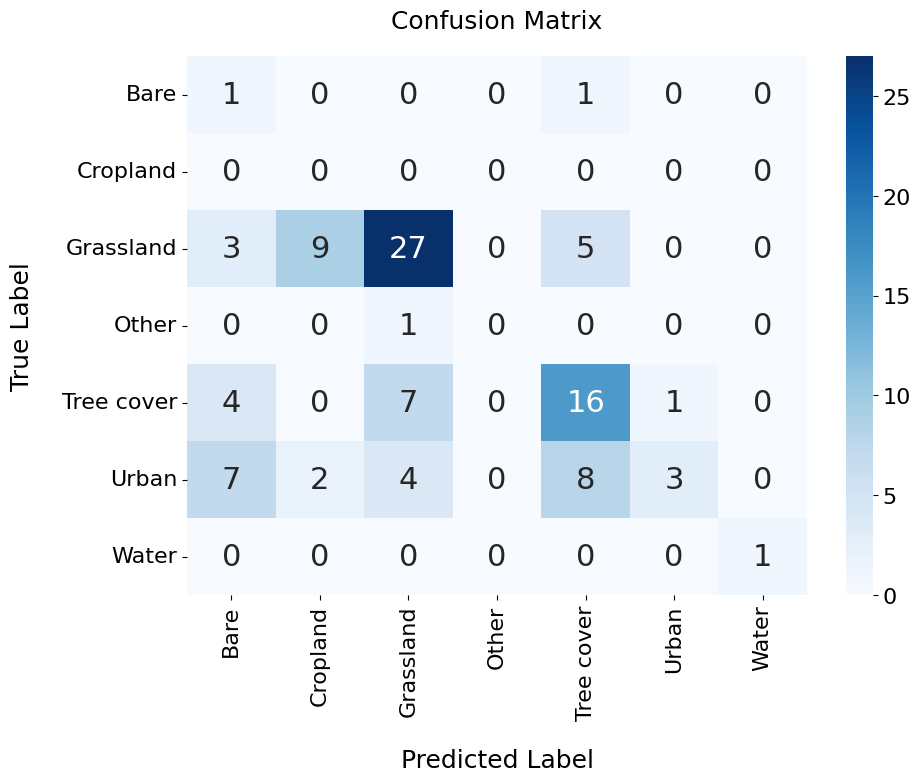

In [ ]:
# Function to load and preprocess Sentinel-2 data for a given region with cloud masking
def load_sentinel2_data(roi):
    sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .map(lambda image: image.updateMask(image.select('QA60').lt(1))) \
        .median() \
        .clip(roi) \
        .select(['B4', 'B8', 'B11'])
    return sentinel2

# Function to load and preprocess Sentinel-1 data for a given region
def load_sentinel1_data(roi):
    sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .select(['VV']) \
        .median() \
        .clip(roi)
    return sentinel1

# Load Sentinel-2 and Sentinel-1 data for the London region
sentinel2_london = load_sentinel2_data(london_roi)
sentinel1_london = load_sentinel1_data(london_roi)

# Combine Sentinel-1 and Sentinel-2 data
combined_london = sentinel2_london.addBands(sentinel1_london)

# Filter the Map to keep only relevant classes: Tree cover (10), Shrubland (20), Grassland (30), Cropland (40), Urban (50), Bare/Sparse vegetation (60), Water (80)
filtered_map = worldcover.updateMask(
    worldcover.eq(10)  # Tree cover
    .Or(worldcover.eq(20))  # Shrubland
    .Or(worldcover.eq(30))  # Grassland
    .Or(worldcover.eq(40))  # Cropland
    .Or(worldcover.eq(50))  # Urban
    .Or(worldcover.eq(60))  # Bare/Sparse vegetation
    .Or(worldcover.eq(80))  # Water
)


# Combine Sentinel-2 and Sentinel-1 data with the filtered Map labels for training
training_image_london = combined_london.addBands(filtered_map.rename('FilteredMap'))

# Sample the combined training images using the filtered Map band
training_data_london = training_image_london.stratifiedSample(
    region=london_roi,
    scale=30,  # Increase scale to reduce the number of pixels sampled
    numPoints=50,  # Reduce the number of samples per class to lower memory usage
    classBand='FilteredMap',  # Use the filtered class band
    seed=0,
    geometries=True
)

# Train a simpler CART classifier instead of Random Forest
cart_classifier = ee.Classifier.smileCart().train(
    features=training_data_london,
    classProperty='FilteredMap',
    inputProperties=['B4', 'B8', 'B11', 'VV']
)

# Define the region of interest for Glasgow for testing
glasgow_roi = ee.Geometry.Rectangle([-4.4, 55.7, -4.1, 55.9])

# Load Sentinel-2 and Sentinel-1 data for Glasgow
sentinel2_glasgow = load_sentinel2_data(glasgow_roi)
sentinel1_glasgow = load_sentinel1_data(glasgow_roi)

# Combine Sentinel-1 and Sentinel-2 data for Glasgow
combined_glasgow = sentinel2_glasgow.addBands(sentinel1_glasgow)

# Classify the Glasgow Sentinel-1 and Sentinel-2 image using the trained CART classifier
classified_glasgow = combined_glasgow.classify(cart_classifier)

# Sample the classified image to get predictions
predicted_samples = classified_glasgow.sample(
    region=glasgow_roi,
    scale=30,
    numPixels=100,
    geometries=True
)

# Convert sampled predictions to GeoJSON and then to GeoDataFrame
predicted_geojson = geemap.ee_to_geojson(predicted_samples)
predicted_gdf = gpd.GeoDataFrame.from_features(predicted_geojson['features'])

# Sample the true labels from WorldCover for Glasgow
true_samples = worldcover.sample(
    region=glasgow_roi,
    scale=30,  # Increase scale to reduce memory usage
    numPixels=100,  # Further reduce the number of pixels to sample
    geometries=True
)

# Convert true labels to GeoJSON and then to GeoDataFrame
true_geojson = geemap.ee_to_geojson(true_samples)
true_gdf = gpd.GeoDataFrame.from_features(true_geojson['features'])

# Ensure 'Map' is of integer type
true_gdf['Map'] = true_gdf['Map'].astype(int)

# Define class names mapping for the broader categories
class_names_mapping = {
    10: 'Tree cover',           # Tree cover
    20: 'Shrubland',            # Shrubland
    30: 'Grassland',            # Grassland
    40: 'Cropland',             # Cropland
    50: 'Urban',                # Urban
    60: 'Bare',  # Bare/Sparse vegetation
    80: 'Water'                 # Water
}


# Map the predicted and true labels to the broader categories
y_pred = [class_names_mapping.get(label, 'Other') for label in predicted_gdf['classification'].values]
y_true = [class_names_mapping.get(label, 'Other') for label in true_gdf['Map'].values]

# Get unique classes
unique_classes = np.unique(np.concatenate((y_true, y_pred)))

# Match actual class names with unique classes in the data
labels = sorted(unique_classes)

# Print accuracy and kappa
accuracy = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa Coefficient: {kappa:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels, labels=labels))

# Compute and print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 annot_kws={"size": 22},
                 xticklabels=labels,
                 yticklabels=labels,
                 cbar=True)
plt.xlabel('Predicted Label', fontsize=18, labelpad=20)
plt.ylabel('True Label', fontsize=18,labelpad=20)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16, rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.title('Confusion Matrix', fontsize=18,pad=20)
plt.show()


**Map Visualization**

In [ ]:
# Define a color palette and class names for the land cover classes
landcover_palette = {
    10: ('Tree cover', '#006400'),        # Dark green for Tree cover (same as ESA)
    20: ('Shrubland', '#FFBB22'),         # Yellow-brown for Shrubland (same as ESA)
    30: ('Grassland', '#FFFF4C'),         # Yellow for Grassland (same as ESA)
    40: ('Cropland', '#F096FF'),          # Purple for Cropland (same as ESA)
    50: ('Urban', '#FA0000'),             # Red for Urban (same as ESA)
    60: ('Bare', '#B4B4B4'),  # Light gray for Bare/Sparse vegetation (same as ESA)
    80: ('Water', '#0064C8')              # Blue for Water (same as ESA)
}



# Create a list of colors and a list of class values
colors = [landcover_palette[key][1] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Create a map centered on Glasgow
Map = geemap.Map(center=[55.85, -4.25], zoom=10)

# Add the classified image to the map
Map.addLayer(classified_glasgow, {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}, 'Classified Land Cover')

# Add a legend to the map
legend_dict = {landcover_palette[key][0]: landcover_palette[key][1] for key in landcover_palette}
Map.add_legend(legend_title="Land Cover Classification", legend_dict=legend_dict)

# Display the map
Map

Map(center=[55.85, -4.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

# Model 10: Classification and Regression Tree (CART)

**Model Training and Testing**


*   Sentinel bands used: Sentinel-2 B4 and B8. Sentinel-1 VV polarization.

*   Training sample scale of 50 meters


*   Stratified sample sieze of 50 points per class at a 50-meter scale


Accuracy: 0.66
Kappa Coefficient: 0.47
Classification Report:
              precision    recall  f1-score   support

        Bare       0.17      0.25      0.20         4
    Cropland       0.00      0.00      0.00         0
   Grassland       0.71      0.88      0.79        48
       Other       0.00      0.00      0.00         1
  Tree cover       0.61      0.48      0.54        23
       Urban       0.86      0.52      0.65        23
       Water       0.00      0.00      0.00         1

    accuracy                           0.66       100
   macro avg       0.34      0.30      0.31       100
weighted avg       0.69      0.66      0.66       100

Confusion Matrix:
[[ 1  0  0  0  1  2  0]
 [ 0  0  0  0  0  0  0]
 [ 2  2 42  0  2  0  0]
 [ 0  0  1  0  0  0  0]
 [ 0  1 11  0 11  0  0]
 [ 3  0  4  0  4 12  0]
 [ 0  0  1  0  0  0  0]]


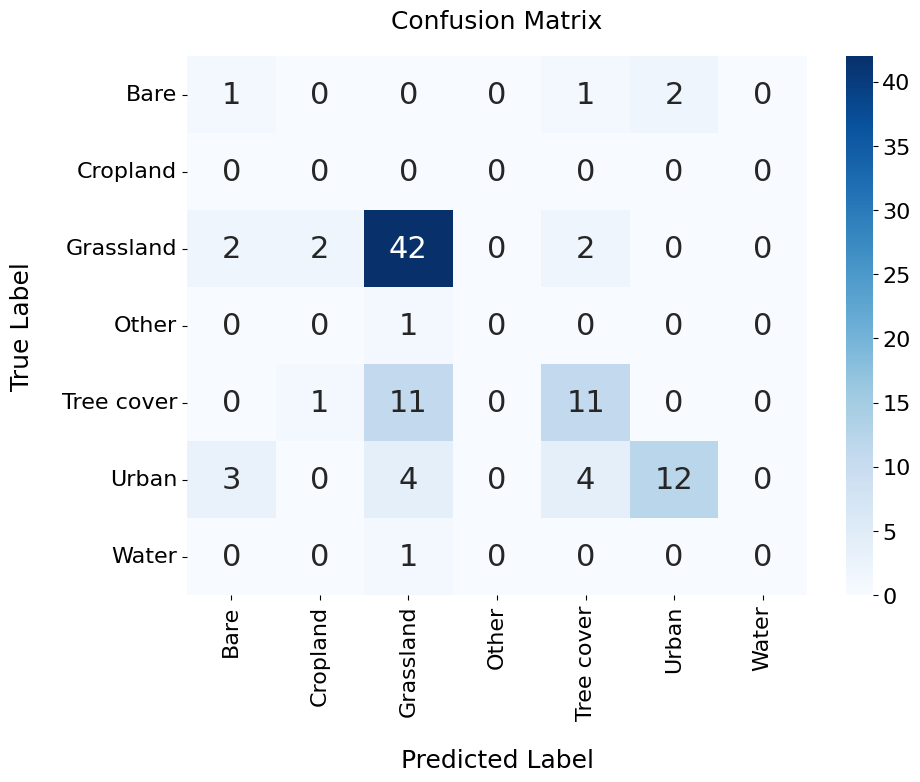

In [ ]:
# Function to load and preprocess Sentinel-2 data for a given region with cloud masking
def load_sentinel2_data(roi):
    sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .map(lambda image: image.updateMask(image.select('QA60').lt(1))) \
        .median() \
        .clip(roi) \
        .select(['B4', 'B8'])  # Reduced to only B4 and B8 bands
    return sentinel2

# Function to load and preprocess Sentinel-1 data for a given region
def load_sentinel1_data(roi):
    sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .select(['VV']) \
        .median() \
        .clip(roi)
    return sentinel1

# Load Sentinel-2 and Sentinel-1 data for the London region
sentinel2_london = load_sentinel2_data(london_roi)
sentinel1_london = load_sentinel1_data(london_roi)

# Combine Sentinel-1 and Sentinel-2 data
combined_london = sentinel2_london.addBands(sentinel1_london)

# Filter the Map to keep only relevant classes: Tree cover (10), Shrubland (20), Grassland (30), Cropland (40), Urban (50), Bare/Sparse vegetation (60), Water (80)
filtered_map = worldcover.updateMask(
    worldcover.eq(10)  # Tree cover
    .Or(worldcover.eq(20))  # Shrubland
    .Or(worldcover.eq(30))  # Grassland
    .Or(worldcover.eq(40))  # Cropland
    .Or(worldcover.eq(50))  # Urban
    .Or(worldcover.eq(60))  # Bare/Sparse vegetation
    .Or(worldcover.eq(80))  # Water
)

# Combine Sentinel-2 and Sentinel-1 data with the filtered Map labels for training
training_image_london = combined_london.addBands(filtered_map.rename('FilteredMap'))

# Sample the combined training images using the filtered Map band
training_data_london = training_image_london.stratifiedSample(
    region=london_roi,
    scale=50,  # Increased scale to reduce the number of pixels sampled
    numPoints=50,  # Reduce the number of samples per class to lower memory usage
    classBand='FilteredMap',  # Use the filtered class band
    seed=0,
    geometries=True
)

# Train a simpler CART classifier instead of Random Forest
cart_classifier = ee.Classifier.smileCart().train(
    features=training_data_london,
    classProperty='FilteredMap',
    inputProperties=['B4', 'B8', 'VV']  # Reduced number of input bands
)

# Define the region of interest for Glasgow for testing
glasgow_roi = ee.Geometry.Rectangle([-4.4, 55.7, -4.1, 55.9])

# Load Sentinel-2 and Sentinel-1 data for Glasgow
sentinel2_glasgow = load_sentinel2_data(glasgow_roi)
sentinel1_glasgow = load_sentinel1_data(glasgow_roi)

# Combine Sentinel-1 and Sentinel-2 data for Glasgow
combined_glasgow = sentinel2_glasgow.addBands(sentinel1_glasgow)

# Classify the Glasgow Sentinel-1 and Sentinel-2 image using the trained CART classifier
classified_glasgow = combined_glasgow.classify(cart_classifier)

# Sample the classified image to get predictions
predicted_samples = classified_glasgow.sample(
    region=glasgow_roi,
    scale=50,  # Increased scale to reduce memory usage
    numPixels=100,  # Further reduce the number of pixels to sample
    geometries=True
)

# Convert sampled predictions to GeoJSON and then to GeoDataFrame
predicted_geojson = geemap.ee_to_geojson(predicted_samples)
predicted_gdf = gpd.GeoDataFrame.from_features(predicted_geojson['features'])

# Sample the true labels from WorldCover for Glasgow
true_samples = worldcover.sample(
    region=glasgow_roi,
    scale=50,  # Increased scale to reduce memory usage
    numPixels=100,  # Further reduce the number of pixels to sample
    geometries=True
)

# Convert true labels to GeoJSON and then to GeoDataFrame
true_geojson = geemap.ee_to_geojson(true_samples)
true_gdf = gpd.GeoDataFrame.from_features(true_geojson['features'])

# Ensure 'Map' is of integer type
true_gdf['Map'] = true_gdf['Map'].astype(int)

# Define class names mapping for the broader categories
class_names_mapping = {
    10: 'Tree cover',           # Tree cover
    20: 'Shrubland',            # Shrubland
    30: 'Grassland',            # Grassland
    40: 'Cropland',             # Cropland
    50: 'Urban',                # Urban
    60: 'Bare',  # Bare/Sparse vegetation
    80: 'Water'                 # Water
}

# Map the predicted and true labels to the broader categories
y_pred = [class_names_mapping.get(label, 'Other') for label in predicted_gdf['classification'].values]
y_true = [class_names_mapping.get(label, 'Other') for label in true_gdf['Map'].values]

# Get unique classes
unique_classes = np.unique(np.concatenate((y_true, y_pred)))

# Match actual class names with unique classes in the data
labels = sorted(unique_classes)

# Print accuracy and kappa
accuracy = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa Coefficient: {kappa:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels, labels=labels))

# Compute and print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 annot_kws={"size": 22},
                 xticklabels=labels,
                 yticklabels=labels,
                 cbar=True)
plt.xlabel('Predicted Label', fontsize=18, labelpad=20)
plt.ylabel('True Label', fontsize=18,labelpad=20)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16, rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.title('Confusion Matrix', fontsize=18,pad=20)
plt.show()



**Map Visualization**

In [ ]:
# Define a color palette and class names for the land cover classes
landcover_palette = {
    10: ('Tree cover', '#006400'),        # Dark green for Tree cover (same as ESA)
    20: ('Shrubland', '#FFBB22'),         # Yellow-brown for Shrubland (same as ESA)
    30: ('Grassland', '#FFFF4C'),         # Yellow for Grassland (same as ESA)
    40: ('Cropland', '#F096FF'),          # Purple for Cropland (same as ESA)
    50: ('Urban', '#FA0000'),             # Red for Urban (same as ESA)
    60: ('Bare', '#B4B4B4'),  # Light gray for Bare/Sparse vegetation (same as ESA)
    80: ('Water', '#0064C8')              # Blue for Water (same as ESA)
}



# Create a list of colors and a list of class values
colors = [landcover_palette[key][1] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Create a map centered on Glasgow
Map = geemap.Map(center=[55.85, -4.25], zoom=10)

# Add the classified image to the map
Map.addLayer(classified_glasgow, {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}, 'Classified Land Cover')

# Add a legend to the map
legend_dict = {landcover_palette[key][0]: landcover_palette[key][1] for key in landcover_palette}
Map.add_legend(legend_title="Land Cover Classification", legend_dict=legend_dict)

# Display the map
Map

Map(center=[55.85, -4.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

# Model 11: Support Vector Machine (SVM)

**Model Training and Testing**

Accuracy: 0.63
Kappa Coefficient: 0.48
Classification Report:
              precision    recall  f1-score   support

        Bare       0.12      1.00      0.21         2
   Grassland       0.87      0.77      0.82        44
       Other       0.00      0.00      0.00         1
  Tree cover       0.60      0.89      0.71        28
       Urban       1.00      0.04      0.08        24
       Water       1.00      1.00      1.00         1

    accuracy                           0.63       100
   macro avg       0.60      0.62      0.47       100
weighted avg       0.80      0.63      0.59       100

Confusion Matrix:
[[ 2  0  0  0  0  0]
 [ 1 34  0  9  0  0]
 [ 1  0  0  0  0  0]
 [ 1  2  0 25  0  0]
 [12  3  0  8  1  0]
 [ 0  0  0  0  0  1]]


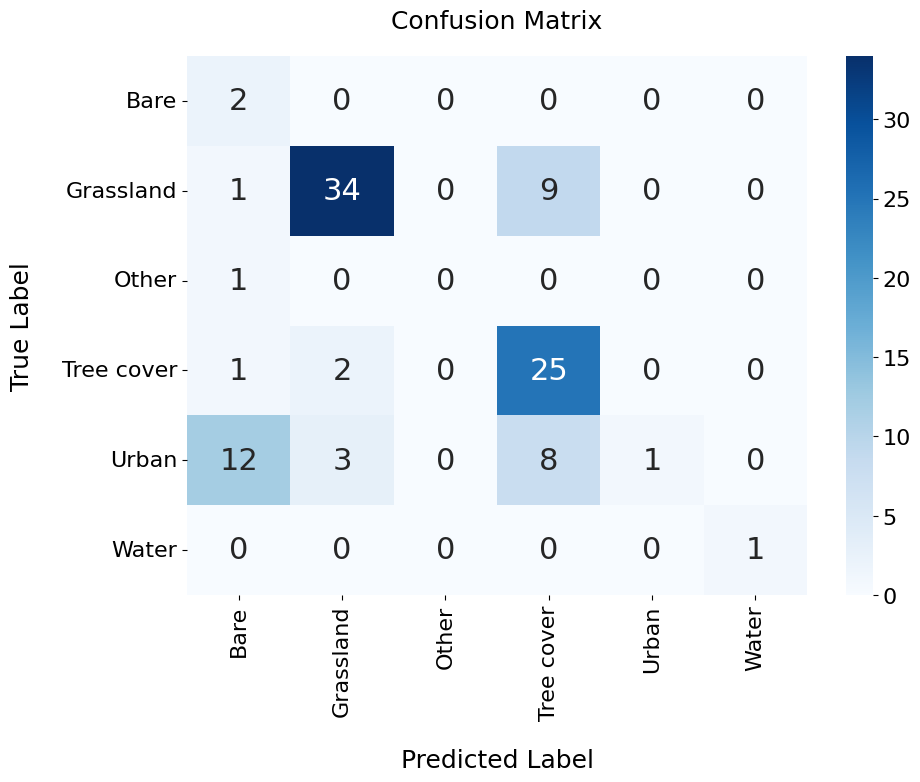

In [ ]:
# Function to load and preprocess Sentinel-2 data for a given region with cloud masking
def load_sentinel2_data(roi):
    sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .map(lambda image: image.updateMask(image.select('QA60').lt(1))) \
        .median() \
        .clip(roi) \
        .select(['B4', 'B8', 'B11'])  # Fewer bands to reduce memory usage
    return sentinel2

# Function to load and preprocess Sentinel-1 data for a given region
def load_sentinel1_data(roi):
    sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .select(['VV']) \
        .median() \
        .clip(roi)
    return sentinel1

# Load Sentinel-2 and Sentinel-1 data for the London region
sentinel2_london = load_sentinel2_data(london_roi)
sentinel1_london = load_sentinel1_data(london_roi)

# Combine Sentinel-1 and Sentinel-2 data
combined_london = sentinel2_london.addBands(sentinel1_london)

# Filter the Map to keep only relevant classes: Tree cover (10), Shrubland (20), Grassland (30), Cropland (40), Urban (50), Bare/Sparse vegetation (60), Water (80)
filtered_map = worldcover.updateMask(
    worldcover.eq(10)  # Tree cover
    .Or(worldcover.eq(20))  # Shrubland
    .Or(worldcover.eq(30))  # Grassland
    .Or(worldcover.eq(40))  # Cropland
    .Or(worldcover.eq(50))  # Urban
    .Or(worldcover.eq(60))  # Bare/Sparse vegetation
    .Or(worldcover.eq(80))  # Water
)

# Combine Sentinel-2 and Sentinel-1 data with the filtered Map labels for training
training_image_london = combined_london.addBands(filtered_map.rename('FilteredMap'))

# Sample the combined training images using the filtered Map band
training_data_london = training_image_london.stratifiedSample(
    region=london_roi,
    scale=30,
    numPoints=50,
    classBand='FilteredMap',  # Use the filtered class band
    seed=0,
    geometries=True
)

# Train an SVM classifier instead of CART
svm_classifier = ee.Classifier.libsvm().train(
    features=training_data_london,
    classProperty='FilteredMap',
    inputProperties=['B4', 'B8', 'B11', 'VV']
)

# Define the region of interest for Glasgow for testing
glasgow_roi = ee.Geometry.Rectangle([-4.4, 55.7, -4.1, 55.9])

# Load Sentinel-2 and Sentinel-1 data for Glasgow
sentinel2_glasgow = load_sentinel2_data(glasgow_roi)
sentinel1_glasgow = load_sentinel1_data(glasgow_roi)

# Combine Sentinel-1 and Sentinel-2 data for Glasgow
combined_glasgow = sentinel2_glasgow.addBands(sentinel1_glasgow)

# Classify the Glasgow Sentinel-1 and Sentinel-2 image using the trained SVM classifier
classified_glasgow = combined_glasgow.classify(svm_classifier)

# Sample the classified image to get predictions
predicted_samples = classified_glasgow.sample(
    region=glasgow_roi,
    scale=30,
    numPixels=100,
    geometries=True
)

# Convert sampled predictions to GeoJSON and then to GeoDataFrame
predicted_geojson = geemap.ee_to_geojson(predicted_samples)
predicted_gdf = gpd.GeoDataFrame.from_features(predicted_geojson['features'])

# Sample the true labels from WorldCover for Glasgow
true_samples = worldcover.sample(
    region=glasgow_roi,
    scale=30,
    numPixels=100,
    geometries=True
)

# Convert true labels to GeoJSON and then to GeoDataFrame
true_geojson = geemap.ee_to_geojson(true_samples)
true_gdf = gpd.GeoDataFrame.from_features(true_geojson['features'])

# Ensure 'Map' is of integer type
true_gdf['Map'] = true_gdf['Map'].astype(int)

# Define class names mapping for the broader categories
class_names_mapping = {
    10: 'Tree cover',           # Tree cover
    20: 'Shrubland',            # Shrubland
    30: 'Grassland',            # Grassland
    40: 'Cropland',             # Cropland
    50: 'Urban',                # Urban
    60: 'Bare',  # Bare/Sparse vegetation
    80: 'Water'                 # Water
}

# Map the predicted and true labels to the broader categories
y_pred = [class_names_mapping.get(label, 'Other') for label in predicted_gdf['classification'].values]
y_true = [class_names_mapping.get(label, 'Other') for label in true_gdf['Map'].values]

# Get unique classes
unique_classes = np.unique(np.concatenate((y_true, y_pred)))

# Match actual class names with unique classes in the data
labels = sorted(unique_classes)

# Print accuracy and kappa
accuracy = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa Coefficient: {kappa:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels, labels=labels))

# Compute and print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 annot_kws={"size": 22},
                 xticklabels=labels,
                 yticklabels=labels,
                 cbar=True)
plt.xlabel('Predicted Label', fontsize=18, labelpad=20)
plt.ylabel('True Label', fontsize=18,labelpad=20)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16, rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.title('Confusion Matrix', fontsize=18,pad=20)
plt.show()


**Map Visualization**

In [ ]:
# Define a color palette and class names for the land cover classes
landcover_palette = {
    10: ('Tree cover', '#006400'),        # Dark green for Tree cover (same as ESA)
    20: ('Shrubland', '#FFBB22'),         # Yellow-brown for Shrubland (same as ESA)
    30: ('Grassland', '#FFFF4C'),         # Yellow for Grassland (same as ESA)
    40: ('Cropland', '#F096FF'),          # Purple for Cropland (same as ESA)
    50: ('Urban', '#FA0000'),             # Red for Urban (same as ESA)
    60: ('Bare', '#B4B4B4'),  # Light gray for Bare/Sparse vegetation (same as ESA)
    80: ('Water', '#0064C8')              # Blue for Water (same as ESA)
}



# Create a list of colors and a list of class values
colors = [landcover_palette[key][1] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Create a map centered on Glasgow
Map = geemap.Map(center=[55.85, -4.25], zoom=10)

# Add the classified image to the map
Map.addLayer(classified_glasgow, {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}, 'Classified Land Cover')

# Add a legend to the map
legend_dict = {landcover_palette[key][0]: landcover_palette[key][1] for key in landcover_palette}
Map.add_legend(legend_title="Land Cover Classification", legend_dict=legend_dict)

# Display the map
Map

Map(center=[55.85, -4.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

# Model 12: Random Forest

**Model Training and Testing**

Accuracy: 0.61
Kappa Coefficient: 0.42
Classification Report:
              precision    recall  f1-score   support

        Bare       0.07      0.50      0.12         2
   Grassland       0.70      0.86      0.78        44
       Other       0.00      0.00      0.00         1
  Tree cover       0.67      0.71      0.69        28
       Urban       1.00      0.04      0.08        24
       Water       1.00      1.00      1.00         1

    accuracy                           0.61       100
   macro avg       0.57      0.52      0.45       100
weighted avg       0.75      0.61      0.57       100

Confusion Matrix:
[[ 1  0  0  1  0  0]
 [ 2 38  0  4  0  0]
 [ 0  1  0  0  0  0]
 [ 2  6  0 20  0  0]
 [ 9  9  0  5  1  0]
 [ 0  0  0  0  0  1]]


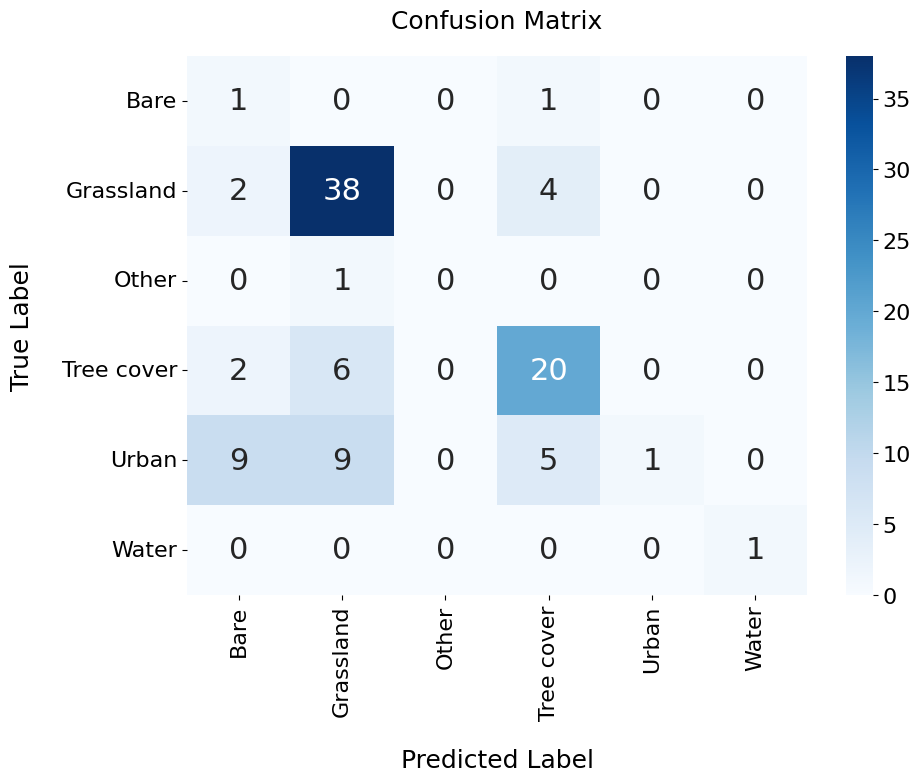

In [ ]:
# Function to load and preprocess Sentinel-2 data for a given region with cloud masking
def load_sentinel2_data(roi):
    sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .map(lambda image: image.updateMask(image.select('QA60').lt(1))) \
        .median() \
        .clip(roi) \
        .select(['B4', 'B8', 'B11'])  # Fewer bands to reduce memory usage
    return sentinel2

# Function to load and preprocess Sentinel-1 data for a given region
def load_sentinel1_data(roi):
    sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(roi) \
        .filterDate('2020-01-01', '2020-12-31') \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .select(['VV']) \
        .median() \
        .clip(roi)
    return sentinel1

# Load Sentinel-2 and Sentinel-1 data for the London region
sentinel2_london = load_sentinel2_data(london_roi)
sentinel1_london = load_sentinel1_data(london_roi)

# Combine Sentinel-1 and Sentinel-2 data
combined_london = sentinel2_london.addBands(sentinel1_london)

# Filter the Map to keep only relevant classes: Tree cover (10), Shrubland (20), Grassland (30), Cropland (40), Urban (50), Bare/Sparse vegetation (60), Water (80)
filtered_map = worldcover.updateMask(
    worldcover.eq(10)  # Tree cover
    .Or(worldcover.eq(20))  # Shrubland
    .Or(worldcover.eq(30))  # Grassland
    .Or(worldcover.eq(40))  # Cropland
    .Or(worldcover.eq(50))  # Urban
    .Or(worldcover.eq(60))  # Bare/Sparse vegetation
    .Or(worldcover.eq(80))  # Water
)

# Combine Sentinel-2 and Sentinel-1 data with the filtered Map labels for training
training_image_london = combined_london.addBands(filtered_map.rename('FilteredMap'))

# Sample the combined training images using the filtered Map band
training_data_london = training_image_london.stratifiedSample(
    region=london_roi,
    scale=30,
    numPoints=50,
    classBand='FilteredMap',  # Use the filtered class band
    seed=0,
    geometries=True
)

# Train a Random Forest classifier instead of CART
rf_classifier = ee.Classifier.smileRandomForest(numberOfTrees=100).train(
    features=training_data_london,
    classProperty='FilteredMap',
    inputProperties=['B4', 'B8', 'B11', 'VV']
)

# Define the region of interest for Glasgow for testing
glasgow_roi = ee.Geometry.Rectangle([-4.4, 55.7, -4.1, 55.9])

# Load Sentinel-2 and Sentinel-1 data for Glasgow
sentinel2_glasgow = load_sentinel2_data(glasgow_roi)
sentinel1_glasgow = load_sentinel1_data(glasgow_roi)

# Combine Sentinel-1 and Sentinel-2 data for Glasgow
combined_glasgow = sentinel2_glasgow.addBands(sentinel1_glasgow)

# Classify the Glasgow Sentinel-1 and Sentinel-2 image using the trained RF classifier
classified_glasgow = combined_glasgow.classify(rf_classifier)

# Sample the classified image to get predictions
predicted_samples = classified_glasgow.sample(
    region=glasgow_roi,
    scale=30,
    numPixels=100,
    geometries=True
)

# Convert sampled predictions to GeoJSON and then to GeoDataFrame
predicted_geojson = geemap.ee_to_geojson(predicted_samples)
predicted_gdf = gpd.GeoDataFrame.from_features(predicted_geojson['features'])

# Sample the true labels from WorldCover for Glasgow
true_samples = worldcover.sample(
    region=glasgow_roi,
    scale=30,
    numPixels=100,
    geometries=True
)

# Convert true labels to GeoJSON and then to GeoDataFrame
true_geojson = geemap.ee_to_geojson(true_samples)
true_gdf = gpd.GeoDataFrame.from_features(true_geojson['features'])

# Ensure 'Map' is of integer type
true_gdf['Map'] = true_gdf['Map'].astype(int)

# Define class names mapping for the broader categories
class_names_mapping = {
    10: 'Tree cover',           # Tree cover
    20: 'Shrubland',            # Shrubland
    30: 'Grassland',            # Grassland
    40: 'Cropland',             # Cropland
    50: 'Urban',                # Urban
    60: 'Bare',  # Bare/Sparse vegetation
    80: 'Water'                 # Water
}

# Map the predicted and true labels to the broader categories
y_pred = [class_names_mapping.get(label, 'Other') for label in predicted_gdf['classification'].values]
y_true = [class_names_mapping.get(label, 'Other') for label in true_gdf['Map'].values]

# Get unique classes
unique_classes = np.unique(np.concatenate((y_true, y_pred)))

# Match actual class names with unique classes in the data
labels = sorted(unique_classes)

# Print accuracy and kappa
accuracy = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(f"Kappa Coefficient: {kappa:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=labels, labels=labels))

# Compute and print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=labels)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 annot_kws={"size": 22},
                 xticklabels=labels,
                 yticklabels=labels,
                 cbar=True)
plt.xlabel('Predicted Label', fontsize=18, labelpad=20)
plt.ylabel('True Label', fontsize=18,labelpad=20)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16, rotation=0)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.title('Confusion Matrix', fontsize=18,pad=20)
plt.show()


**Map Visualization**

In [ ]:
# Define a color palette and class names for the land cover classes
landcover_palette = {
    10: ('Tree cover', '#006400'),        # Dark green for Tree cover (same as ESA)
    20: ('Shrubland', '#FFBB22'),         # Yellow-brown for Shrubland (same as ESA)
    30: ('Grassland', '#FFFF4C'),         # Yellow for Grassland (same as ESA)
    40: ('Cropland', '#F096FF'),          # Purple for Cropland (same as ESA)
    50: ('Urban', '#FA0000'),             # Red for Urban (same as ESA)
    60: ('Bare', '#B4B4B4'),  # Light gray for Bare/Sparse vegetation (same as ESA)
    80: ('Water', '#0064C8')              # Blue for Water (same as ESA)
}

# Create a list of colors and a list of class values
colors = [landcover_palette[key][1] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Create a map centered on Glasgow
Map = geemap.Map(center=[55.85, -4.25], zoom=10)

# Add the classified image to the map
Map.addLayer(classified_glasgow, {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}, 'Classified Land Cover')

# Add a legend to the map
legend_dict = {landcover_palette[key][0]: landcover_palette[key][1] for key in landcover_palette}
Map.add_legend(legend_title="Land Cover Classification", legend_dict=legend_dict)

# Display the map
Map

Map(center=[55.85, -4.25], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
# Define your classified image and region of interest.
region_of_interest = glasgow_roi

# Set up the export task to Google Drive
task = ee.batch.Export.image.toDrive(
    image=classified_glasgow,  # Your classified image
    description='Edinburgh_Classified_Map',  # Description of the export task
    folder='Classified_maps',
    fileNamePrefix='Model1_Edinburgh_Classified_Map',
    region=region_of_interest,
    scale=10,  # Resolution in meters (adjust based on your image's resolution)
    maxPixels=1e13  # Maximum number of pixels allowed in the export
)

# Start the export task
task.start()

print("Export to Google Drive started. Check your Earth Engine tasks and Google Drive.")


Export to Google Drive started. Check your Earth Engine tasks and Google Drive.


# Edinburgh Maps

**Sentinel-2**

In [ ]:
# Load Sentinel-2 ImageCollection, filtering by date and cloud cover
sentinel_2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(edinburgh_roi) \
    .filterDate('2023-01-01', '2023-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .median()  # Median composite to reduce cloud cover

# Select the RGB bands (B4, B3, B2 for Red, Green, Blue)
rgb_bands = sentinel_2.select(['B4', 'B3', 'B2'])

# Visualization parameters for natural color (RGB)
visualization_params = {
    'min': 0,
    'max': 3000,
    'gamma': [1.4, 1.4, 1.4]  # Adjust for better contrast
}

# Create a custom function to add Earth Engine layers to a Folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data © Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add the custom method to the folium Map class
folium.Map.add_ee_layer = add_ee_layer

# Center the map on the region of interest
center = edinburgh_roi.centroid().coordinates().getInfo()

# Create a folium map centered on Edinburgh
map = folium.Map(location=[center[1], center[0]], zoom_start=12)

# Add the Sentinel-2 RGB layer to the map
map.add_ee_layer(rgb_bands.clip(edinburgh_roi), visualization_params, 'Sentinel-2 Natural Color')

# Add a layer control panel to the map
map.add_child(folium.LayerControl())

# Display the map
map


**Esa Worldcover Map 2020 (true labels)**

In [ ]:
# Define a color palette and class names for the land cover classes
landcover_palette = {
    10: ('Tree cover', '#006400'),        # Dark green for Tree cover (same as ESA)
    20: ('Shrubland', '#FFBB22'),         # Yellow-brown for Shrubland (same as ESA)
    30: ('Grassland', '#FFFF4C'),         # Yellow for Grassland (same as ESA)
    40: ('Cropland', '#F096FF'),          # Purple for Cropland (same as ESA)
    50: ('Urban', '#FA0000'),             # Red for Urban (same as ESA)
    60: ('Bare', '#B4B4B4'),              # Light gray for Bare/Sparse vegetation (same as ESA)
    80: ('Water', '#0064C8')              # Blue for Water (same as ESA)
}

# Extract colors and corresponding class labels
colors = [landcover_palette[key][1] for key in landcover_palette]
labels = [landcover_palette[key][0] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Visualization parameters using the custom palette
visualization_params = {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}

# Create a custom function to add Earth Engine layers to a Folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data © Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add the custom method to the folium Map class
folium.Map.add_ee_layer = add_ee_layer

# Function to add a legend to the map (positioned in the bottom-right corner)
def add_legend(map_obj, title, labels, colors):
    legend_html = '''
    <div style="
        position: fixed;
        bottom: 30px; right: 30px; width: 200px; height: 300px;
        border:2px solid grey; z-index:9999; font-size:14px;
        background-color:white; opacity: 0.85;
        padding: 10px;">
        <b>{}</b><br>
    '''.format(title)

    for label, color in zip(labels, colors):
        legend_html += '<i style="background:{}; width: 18px; height: 18px; float: left; margin-right: 8px;"></i>{}<br>'.format(color, label)

    legend_html += '</div>'
    map_obj.get_root().html.add_child(folium.Element(legend_html))

# Center the map on the region of interest
center = edinburgh_roi.centroid().coordinates().getInfo()

# Create a folium map centered on Edinburgh
map = folium.Map(location=[center[1], center[0]], zoom_start=12)

# Add the ESA WorldCover layer to the map using the specified color palette
map.add_ee_layer(worldcover.clip(edinburgh_roi), visualization_params, 'ESA WorldCover')

# Add a layer control panel to the map
map.add_child(folium.LayerControl())

# Add the legend with the land cover classification, positioned in the bottom-right corner
add_legend(map, 'Land Cover Classification', labels, colors)

# Display the map
map


# Glasgow Maps


**Sentinel-2**

In [ ]:
# Load Sentinel-2 ImageCollection, filtering by date and cloud cover
sentinel_2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(glasgow_roi) \
    .filterDate('2023-01-01', '2023-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .median()  # Median composite to reduce cloud cover

# Select the RGB bands (B4, B3, B2 for Red, Green, Blue)
rgb_bands = sentinel_2.select(['B4', 'B3', 'B2'])

# Visualization parameters for natural color (RGB)
visualization_params = {
    'min': 0,
    'max': 3000,
    'gamma': [1.4, 1.4, 1.4]  # Adjust for better contrast
}

# Create a custom function to add Earth Engine layers to a Folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data © Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add the custom method to the folium Map class
folium.Map.add_ee_layer = add_ee_layer

# Center the map on the region of interest
center = glasgow_roi.centroid().coordinates().getInfo()

# Create a folium map centered on Edinburgh
map = folium.Map(location=[center[1], center[0]], zoom_start=12)

# Add the Sentinel-2 RGB layer to the map
map.add_ee_layer(rgb_bands.clip(glasgow_roi), visualization_params, 'Sentinel-2 Natural Color')

# Add a layer control panel to the map
map.add_child(folium.LayerControl())

# Display the map
map


**Esa Worldcover Map 2020 (true labels)**

In [ ]:
# Define a color palette and class names for the land cover classes
landcover_palette = {
    10: ('Tree cover', '#006400'),        # Dark green for Tree cover (same as ESA)
    20: ('Shrubland', '#FFBB22'),         # Yellow-brown for Shrubland (same as ESA)
    30: ('Grassland', '#FFFF4C'),         # Yellow for Grassland (same as ESA)
    40: ('Cropland', '#F096FF'),          # Purple for Cropland (same as ESA)
    50: ('Urban', '#FA0000'),             # Red for Urban (same as ESA)
    60: ('Bare', '#B4B4B4'),              # Light gray for Bare/Sparse vegetation (same as ESA)
    80: ('Water', '#0064C8')              # Blue for Water (same as ESA)
}

# Extract colors and corresponding class labels
colors = [landcover_palette[key][1] for key in landcover_palette]
labels = [landcover_palette[key][0] for key in landcover_palette]
class_values = list(landcover_palette.keys())

# Visualization parameters using the custom palette
visualization_params = {
    'min': min(class_values),
    'max': max(class_values),
    'palette': colors
}

# Create a custom function to add Earth Engine layers to a Folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data © Google Earth Engine',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add the custom method to the folium Map class
folium.Map.add_ee_layer = add_ee_layer

# Function to add a legend to the map (positioned in the bottom-right corner)
def add_legend(map_obj, title, labels, colors):
    legend_html = '''
    <div style="
        position: fixed;
        bottom: 30px; right: 30px; width: 200px; height: 300px;
        border:2px solid grey; z-index:9999; font-size:14px;
        background-color:white; opacity: 0.85;
        padding: 10px;">
        <b>{}</b><br>
    '''.format(title)

    for label, color in zip(labels, colors):
        legend_html += '<i style="background:{}; width: 18px; height: 18px; float: left; margin-right: 8px;"></i>{}<br>'.format(color, label)

    legend_html += '</div>'
    map_obj.get_root().html.add_child(folium.Element(legend_html))

# Center the map on the region of interest (Glasgow)
center = glasgow_roi.centroid().coordinates().getInfo()

# Create a folium map centered on Glasgow
map = folium.Map(location=[center[1], center[0]], zoom_start=12)

# Add the ESA WorldCover layer to the map using the specified color palette
map.add_ee_layer(worldcover.clip(glasgow_roi), visualization_params, 'ESA WorldCover')

# Add a layer control panel to the map
map.add_child(folium.LayerControl())

# Add the legend with the land cover classification, positioned in the bottom-right corner
add_legend(map, 'Land Cover Classification', labels, colors)

# Display the map
map
